In [ ]:
#Run this only in google colab

#!pip install tslearn
#!git clone https://github.com/marcussteinbacher/modalsplit
#%cd /content/modalsplit

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, fixed, Output, Layout
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from ipyleaflet import Map, Marker, GeoJSON, Popup, Choropleth, LegendControl, MarkerCluster, Polyline, CircleMarker, LayerGroup,WidgetControl,basemaps
from branca import colormap
import networkx as nx
from scipy.interpolate import interp1d
from functools import partial
import random
import warnings

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tslearn.clustering import TimeSeriesKMeans, silhouette_score as ts_silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.datasets import CachedDatasets

sns.set()

/home/marcus/miniconda3/envs/modalsplit/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Data Exloration and Visualization

In [24]:
#IMPORTING ALL PREPROCESSED DATASETS

df_eurostat_eu = pd.read_pickle("data/pickle/df_eurostat_eu.pkl")
df_eurostat_regio = pd.read_pickle("data/pickle/df_eurostat_regio.pkl")
df_eurostat_urban = pd.read_pickle("data/pickle/df_eurostat_urban.pkl")
df_gapminder = pd.read_pickle("data/pickle/df_gapminder.pkl")
df_unece = pd.read_pickle("data/pickle/df_unece.pkl")


In [25]:
#CUSTOM GRID OF CHECKBOXES WIDGET

class CheckboxGrid:
    LAYOUT = widgets.Layout(display="flex",flex_flow="row wrap")
    
    def __init__(self,l:list[str]):
        self.__boxes = [widgets.Checkbox(description = c,layout=widgets.Layout(width="25%",margin="0px",padding="0px")) for c in l]
        self.__names = l

        self.ui = widgets.Box(children = self.__boxes, layout = self.LAYOUT) 
        self.kwargs = {name:box for name,box in zip(self.__names,self.__boxes)}

def color_gen(colors = sns.color_palette("tab10")):
    i = 0
    while True:
        yield colors[i%len(colors)]
        i += 1


## Eurostat EU

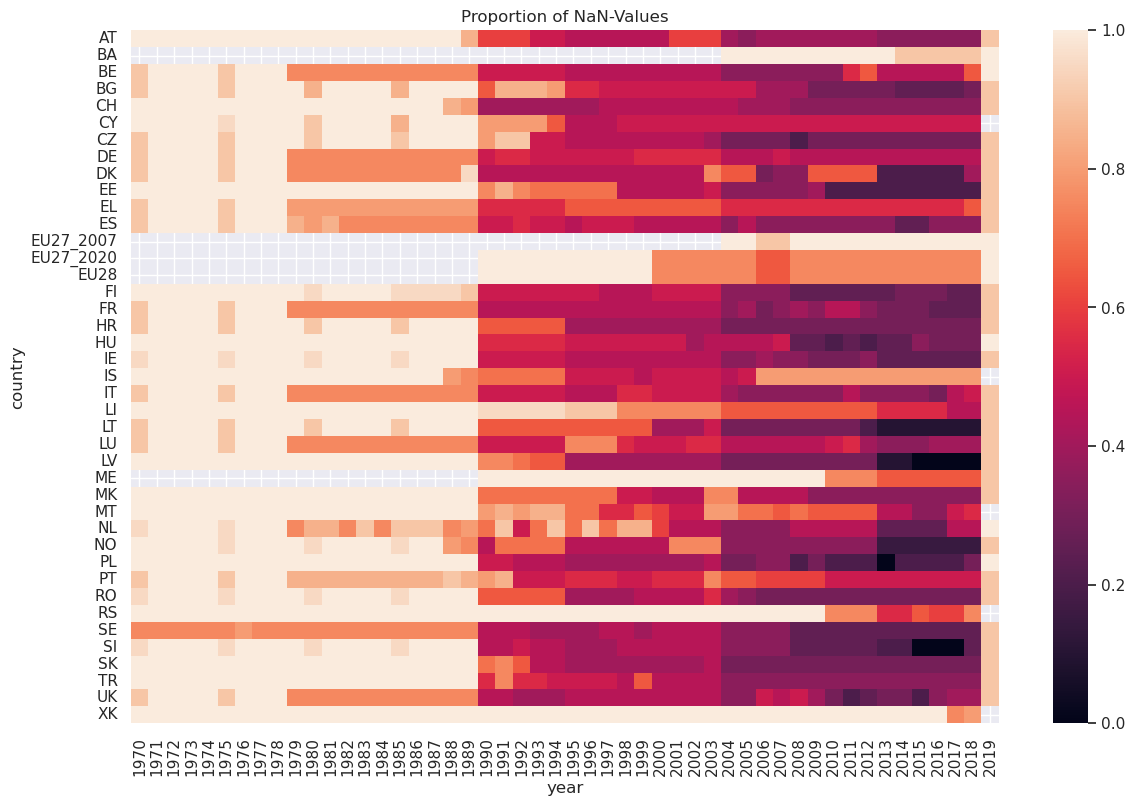

In [26]:
plt.figure(figsize = (14,9))
nan_country_year = df_eurostat_eu.isna().sum(axis=1).unstack(level=0)/df_eurostat_eu.shape[1]
ax = sns.heatmap(nan_country_year)
ax.set_title("Proportion of NaN-Values")
plt.show()

#CONCLUSIO: Two major steps in the availability of values in 1990 and 2004 until 2018

In [155]:


def bar(year,countries,data=df_eurostat_eu,rescale = True, ax = None):
    gen = color_gen()
    if not ax:
        fig,ax = plt.figure(figsize=(10,9),tight_layout=True),plt.axes()
        
    df = data.loc[(year,countries),:].copy()
    
    #Positionen und breiten der bars
    pos = [i for i in range(len(df.columns))] #[0,1,2,3, ..]
    if len(countries) > 0:
        width = 0.8/len(countries)
    else:
        width = 0.8

    for i,c in enumerate(countries):
        #position for every bar
        x_ = [x-0.4 + width/2 + i*width for x in pos]
        # Rescaling every feature to a scale 0..1
        if rescale:
            ax.set_ylabel("Rescaled to 0..1")
            for col in df.columns:
                df[col] = list(map(lambda x: (x-min(df[col]))/(max(df[col])-min(df[col])) if min(df[col]) != max(df[col]) else 0, df[col]))
        
        h = df.loc[(year,c),:].values
        ax.bar(x_,h,width = width,color = next(gen),label = c)
        
    plt.xticks(ticks = [i for i in range(len(df.columns))],labels = df.columns,rotation = 90)
    
    with warnings.catch_warnings(category=UserWarning,action="ignore"):
        ax.legend()
    
    plt.show()

countries = df_eurostat_eu.index.get_level_values(1).unique().values
years = [int(y) for y in df_eurostat_eu.index.get_level_values(0).unique()]

grid = CheckboxGrid(countries)
box_ui = grid.ui
kwargs = grid.kwargs


slider_ui = widgets.IntSlider(value = 2010, min = min(years), max = max(years),continuous_update=False)
kwargs["y_slider"] = slider_ui

scale_box = widgets.RadioButtons(options = [("MinMax Scaler",True),("Absolute",False)])
kwargs["rescale"] = scale_box

sel_ui = widgets.HBox([slider_ui,scale_box])

selected = [] #for selected countries
def eu_bar_handler(**kwargs):
    #AGGREGATE USER INPUT
    selected.clear()
    year = kwargs["y_slider"]
    if "rescale" in kwargs.keys():
        rescale = kwargs.pop("rescale")
    for key in kwargs:
        if kwargs[key] == True:
            selected.append(key)

    #DO SOMETHING
    try:
        bar(year,selected,rescale=rescale)
    except:
        print("No Data!")

out1 = interactive_output(eu_bar_handler,kwargs)
display(box_ui,sel_ui,out1)

Box(children=(Checkbox(value=False, description='AT', layout=Layout(margin='0px', padding='0px', width='25%'))…

Output()

In [154]:
def print_lines(attribute,c,d_range,data):
    fig = plt.figure(figsize = (12,6))
    ax = plt.axes()
    
    ids = pd.IndexSlice
    for country in c:
        df = data.loc[ids[:,country],attribute]
        x = df.index.get_level_values(0)
        ax.plot(x,df.values,label = country)

    with warnings.catch_warnings(category=UserWarning,action="ignore"):
        ax.legend()
        
    ax.set_title(attribute)
    plt.xlim(d_range)
    
    plt.show()

countries = df_eurostat_eu.index.get_level_values(1).unique()
years = df_eurostat_eu.index.get_level_values(0).unique()
attributes = df_eurostat_eu.columns

cb_grid = CheckboxGrid(countries)
cb_ui = cb_grid.ui
kwargs = cb_grid.kwargs

attr_ui = widgets.Dropdown(options = attributes)
range_ui = widgets.IntRangeSlider(value = (1990,2018),min =min(years) ,max = max(years),continuous_update=False)

kwargs["attr"] = attr_ui
kwargs["d_range"] = range_ui

kwargs["data"] = fixed(df_eurostat_eu) #change this if plotting another dataframe


b = widgets.HBox([attr_ui,range_ui])

selected = []
def line_handler(**kwargs):
    #AGGREGATE USER INPUT
    selected.clear()
    attr = kwargs["attr"]
    d_range = kwargs["d_range"]
    data = kwargs["data"]
    for key in kwargs:
        if key in countries and kwargs[key] == True:
            selected.append(key)
            
    #DO SOMETHING
    print_lines(attr,selected,d_range,data=data)

out2 = interactive_output(line_handler,kwargs)
display(cb_ui,b,out2)

#Conclusio: Schienenverkehr mio.PKM und 1000 Psg. aus unece DataFrame, da dort über größeren Zeitraum enthalten

Box(children=(Checkbox(value=False, description='AT', layout=Layout(margin='0px', padding='0px', width='25%'))…

Output()

In [176]:
# INTERACTIVE MAP: TWO FEATURE COMPARISON PER COUNTRY
def filter_geo(cat,val,geojson):
    """
    Filter GeoJSON Data on given category and value
    params:
    - cat: Category: str; one of GeoJSON "properties" key
    - val: value to filter on; can be list
    - geojson: GeoJSON data to be filtered
    returns: GeoJSON object (dict)
    """
    res = {}
    res["type"] = geojson["type"]
    res["features"] = []
    res["crs"] = geojson["crs"]
    if not type(val) == list:
        val = [val]
    for v in val:
        for entity in geojson["features"]:
            if entity["properties"][cat] == v:
                res["features"].append(entity)
    return res

with open("data/geo/NUTS_RG_10M_2021_4326.geo.json","r",encoding="utf-8") as f:
    geo_data = json.load(f)
    
out3 = Output()

def make_plot(f1,f2,df):
    fig,ax = plt.figure(figsize=(10,5)),plt.axes()
    features = [f1,f2]
    x = df.index.get_level_values(0)
    ax.plot(x,df[f1].values,label = f1,color = "tab:blue")
    ax.set_ylabel(f1)
    ax1 = plt.twinx()
    ax1.plot(x,df[f2].values,label = f2,color = "tab:red")
    ax1.set_ylabel(f2)
    plt.xlim((1990,2018))
    fig.legend()
    plt.show()

#GUI UNTER MAP
features = df_eurostat_eu.columns
d1 = widgets.Dropdown(options = features,value=features[14])
d2 = widgets.Dropdown(options = features,value = features[3])
drops = [d1,d2]
names = ["dd_"+str(i) for i in range(len(drops))]
drop_ui = widgets.HBox(drops)

def click_handler(event=None, feature=None, id=None, properties=None):
    out3.clear_output()
    #DO SOMETHING
    ids = pd.IndexSlice
    try:
        df = df_eurostat_eu.loc[ids[:,id],:]
        features = df.columns
        years = df.index.get_level_values(0)

        graph = interactive_output(make_plot,{"f1":drops[0],"f2":drops[1],"df":fixed(df)})
        #DISPLAY OUTPUT
        with out3:
            display(id)
            display(drop_ui)
            display(graph)
            
    except KeyError as e:
        with out3:
            print("No data for {}".format(e.args[0]))
        

countries = list(df_eurostat_eu.index.get_level_values(1))
gjson = filter_geo("LEVL_CODE",0,geo_data)

m1 = Map(center = (49.15,12.35),zoom = 4)
geojson = GeoJSON(data = gjson,hover_style={'fillColor': 'red'})
geojson.on_click(click_handler)
m1.add_layer(geojson)

display(m1)
out3

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Output()

In [150]:
#CUSTOM LEGEND CLASS FOR CHOROPLETH MAPS
class ChoroLegend:
    def __init__(self,data,n_elems=10,scale="lin",cmap=colormap.linear.GnBu_07):
        """
        params:
        - data: List of numerical values to build legend for
        - n_elems: Number of elements in legend
        - cmap: branca.colormap.LinearColormap object; Linear Colormap instance
        """
        self.colormap = cmap.to_step(n=n_elems,method = scale, data = data)
        self.index = self.colormap.index
        self.colors = [self.colormap(i) for i in self.index]
        self.legend = {int(i):c for i,c in zip(self.index,self.colors)}   


def remove_controls(m,ctrl_type=LegendControl):
    """
    Removes an control object from a map m.
    params:
    - m: ipyleaflet Map
    - ctrl_type: ipyleaflet control class; default LegendControl
    """
    l = []
    for ctrl in m.controls:
        if not isinstance(ctrl,ctrl_type):
            l.append(ctrl)
    m.controls = tuple(l)
    
def remove_elements(m,elem_type=Choropleth):
    """
    Removes all elements from a Map's layers attribute (m.layers) which are type elem_type
    params:
    - m: ipyleaflet.Map instance
    - elem_type: ipyleaflet class
    """
    new_layers = []
    for layer in m.layers:
        if not isinstance(layer,elem_type):
            new_layers.append(layer)
    m.layers = tuple(new_layers)

with open("data/geo/NUTS_RG_10M_2021_4326.geo.json","r",encoding="utf-8") as f:
    geo_data_nuts = json.load(f)

countries = df_eurostat_eu.index.get_level_values(1).unique()
years = df_eurostat_eu.index.get_level_values(0).unique()
attributes = df_eurostat_eu.columns       

#BUILDING GUI
slider = widgets.IntSlider(value=2010,min = min(years),max = max(years),contiuous_update=False)
drop = widgets.Dropdown(options = attributes)
ui = widgets.HBox([drop,slider])

m2 = Map(center = (49.15,12.35),zoom = 4)
gjson_nuts = filter_geo("LEVL_CODE",0,geo_data_nuts)

def make_dict(feature,year,data:pd.DataFrame,nuts=None):
    """
    Retruns a dictionary of not nan k,v pairs to use with ipyleaflet Choropleth map with
    the keys beeing ids (e.g. country codes) and the value to use for coloring the map.
    params:
    - feature: One of DataFrame's columns; str; e.g. "PKW pro 1000 EW"
    - year: Integer year
    - data: DataFrame
    """
    
    ids = pd.IndexSlice
    if nuts:
        match nuts:
            case "NUTS0":
                regions = list(filter(lambda s: sum(c.isdigit() for c in s) == 0,data.index.get_level_values(1)))
            case "NUTS1":
                regions = list(filter(lambda s: sum(c.isdigit() for c in s) == 1,data.index.get_level_values(1)))
            case "NUTS2":
                regions = list(filter(lambda s: sum(c.isdigit() for c in s) == 2,data.index.get_level_values(1)))
            case "NUTS3":
                regions = list(filter(lambda s: sum(c.isdigit() for c in s) == 3,data.index.get_level_values(1)))
                
        df = data.loc[ids[year,regions],feature].dropna()
    else:
        df = data.loc[ids[year,:],feature].dropna()
        
    values = df.values
    keys = df.index.get_level_values(1)
    
    return {k:v for k,v in zip(keys,values)}

def choro_map(feature,year,data,m,gjson):
    """
    Builds a choropleth map including legend; 
    Prerequisites: Map object m and dict gjson in global namespace; gjson in Geojson format.
    params:
    - feature: One of DataFrame's columns; str; e.g. "PKW pro 1000 EW"
    - year: Integer year
    - data: DataFrame
    Usage:
    m = Map(**kwargs)
    gjson = {...}
    choromap("PKW pro 1000 EW",2010,df_eurostat_eu)
    m
    """
    # REMOVE EXISTING LEGENDS IF THERE ARE ANY (otherwise they pile up)
    remove_controls(m)
    # REMOVE EXISTING CHOROPLETH MAPS IF THERE ARE ANY
    remove_elements(m,elem_type=Choropleth)
    
    #ONLY KEEP COMMON KEYS IN CHORO DATA AND GEO DATA
    choro_data = make_dict(feature,year,data)
    cntrs = []
    for d in gjson["features"]:
        if d["properties"]["LEVL_CODE"] == 0 and d["properties"]["FID"] in choro_data.keys():
            cntrs.append(d["properties"]["FID"])
        
    common = list(set(cntrs) & set(choro_data.keys()))
    
    geo_data = filter_geo("FID",cntrs,gjson)
    remv=[]
    for k in choro_data:
        if not k in cntrs:
            remv.append(k)
    for k in remv:
        choro_data.pop(k)
    
    #GENERATE MAP
    if len(choro_data) > 0:
        #BUILD LEGEND
        lobj = ChoroLegend(choro_data.values(),n_elems=6)
        legend = LegendControl(lobj.legend,position="topright")
        #CHOROPLETH
        choro = Choropleth(geo_data=geo_data,choro_data=choro_data,colormap=lobj.colormap,style={'fillOpacity': 0.8})
        m.add_layer(choro)
        m.add_control(legend)

interact(choro_map,feature=drop,year=slider,data = fixed(df_eurostat_eu),m=fixed(m2),gjson = fixed(gjson_nuts))
display(m2)
#TODO: Add gejson.onclick event mit popup countrycode und value

interactive(children=(Dropdown(description='feature', options=('Schienenverkehr Millionen Personenkilometer', …

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [47]:
# in Kapitel:ML PART 1: Kurven ausgewählter features modellieren -> Konvergenz? Trend für Zukunft?
# d.h. durchschnittliche Kurve eines features über alle länder eines clusters

In [48]:
#ML PART 2: Verkehrsdaten mit Sozioökonomischen Daten zusammenbringen:
#correlation matrix
#Pers.bef.% - GDP per capita
#PKWpro100EW - GDP per capita
#straßenKM - pop.density
#...
#--> cluster?

## Eurostat regio

In [55]:
fr = list(filter(lambda s: s.startswith("FR")==True,df_eurostat_regio.index.get_level_values(1)))

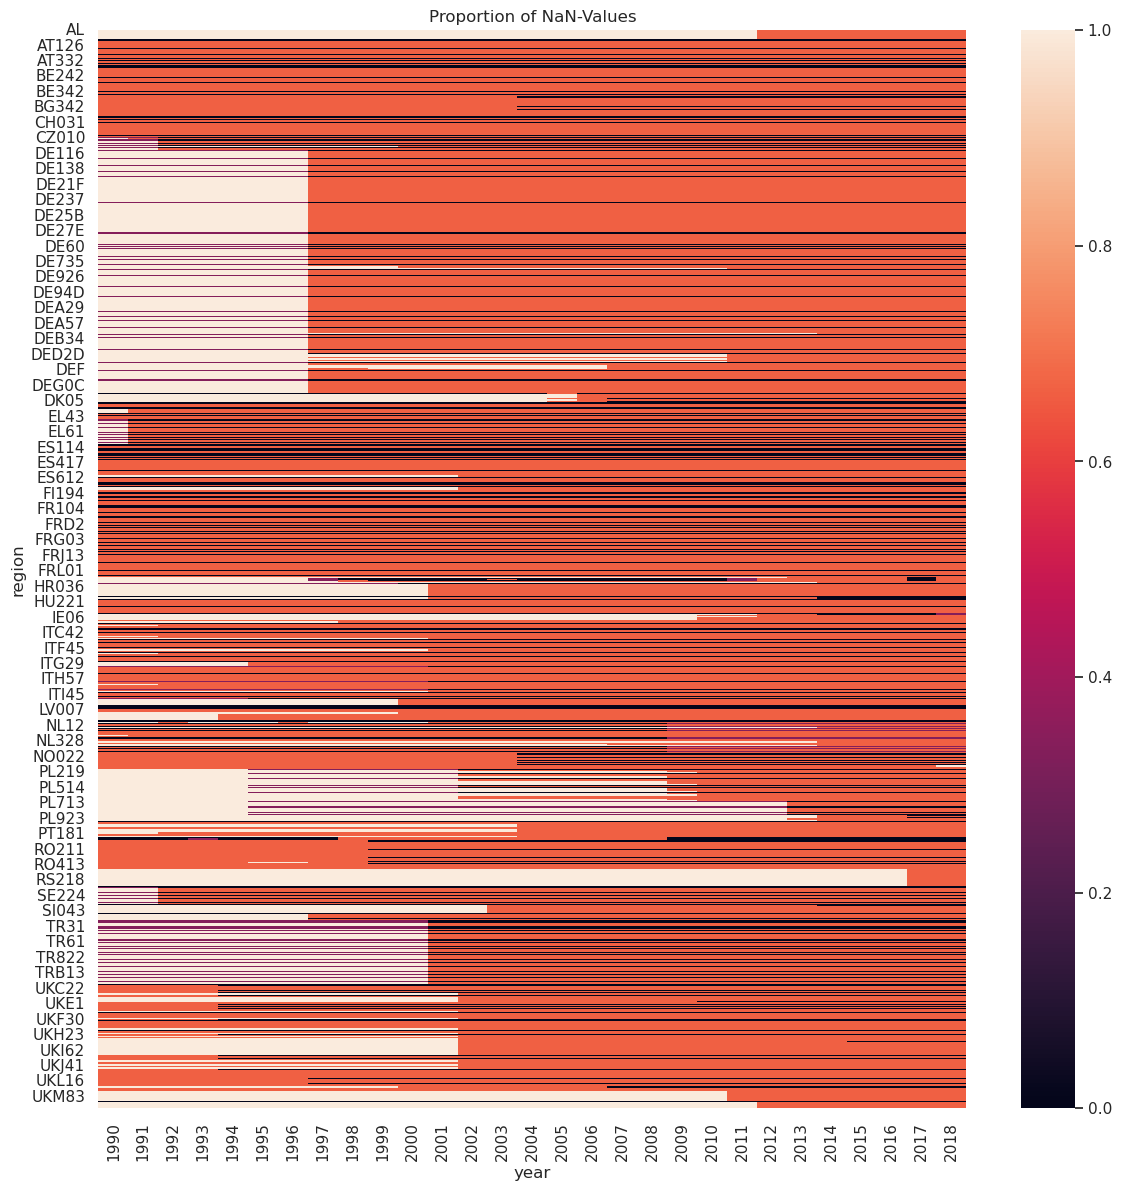

In [43]:
plt.figure(figsize = (14,14))
nan_country_year = df_eurostat_regio.isna().sum(axis=1).unstack(level=0)/df_eurostat_regio.shape[1]
ax = sns.heatmap(nan_country_year)
ax.set_title("Proportion of NaN-Values")
plt.show()

In [133]:
with open("data/geo/capitals.json","r") as f:
    cap_locs = json.load(f)
ids = [feature["id"] for feature in cap_locs["features"]]
locs = [feature["geometry"]["coordinates"][::-1] for feature in cap_locs["features"]]
capitals = {k:v for k,v in zip(ids,locs)}

In [177]:
#ÜBERBLICK ÜBER VERSCHIEDENE NUTS LEVELS
with open("data/geo/NUTS_RG_10M_2021_4326.geo.json","r",encoding="utf-8") as f:
    geo_data_nuts = json.load(f)

with open("data/geo/city_locs.json","r") as f:
    ct_locs = json.load(f)

def filter_nuts(lvl_str,geojson):
    """
    Get all NUTS regions on a certain level for which there are coordinates available. 
    params: 
    - lvl_str: e.g. "NUTS0" 
    - gejson: GeoJSON to get NUTS regions from
    returns: List of regions on NUTS level lvl_str 
    """
    lvl = int(lvl_str[-1])
    c = []
    for d in geojson["features"]:
        if d["properties"]["LEVL_CODE"] == lvl:
            c.append(d["properties"]["FID"])
    return c

def filter_data(df,arr):
    """
    Filters a DataFrame keeping only index values in arr
    """
    c = df.index.get_level_values(1).unique()
    f = list(set(c) & set(arr))
    ids = pd.IndexSlice
    return df.loc[ids[:,f],:]

def nuts_click_handler(**kwargs):
    #print("click geojson")
    print(kwargs["properties"])
    txt = kwargs["feature"]["properties"]["NUTS_ID"]
    msg = widgets.HTML(value=txt)
    loc = capitals[txt]
    pop = Popup(location = loc,child =msg)
    m.add(pop)


def handler_nuts(data=df_eurostat_regio,**kwargs):
    remove_elements(m,GeoJSON)
    geo = kwargs["gjson"]
    nuts = filter_nuts(kwargs["nuts_lvl"],geo)
    df = filter_data(data,nuts)
    cntrs = list(df.index.get_level_values(1).unique())
    geo_data = filter_geo("FID",cntrs,geo)
    
    geojson = GeoJSON(data = geo_data,hover_style={'fillColor': 'blue'})
    m.add_layer(geojson)
    #geojson.on_click(nuts_click_handler)
    #geojson.on_click(nuts_click_handler)
    display(m)

nuts_ui = widgets.Dropdown(options = ["NUTS0","NUTS1","NUTS2"],value = "NUTS0")

m = Map(center = (49.15,12.35),zoom = 4)

kwargs = {}
kwargs["nuts_lvl"] = nuts_ui
kwargs["gjson"] = fixed(geo_data_nuts)

out4 = interactive_output(handler_nuts,kwargs)

display(nuts_ui,out4)


Dropdown(options=('NUTS0', 'NUTS1', 'NUTS2'), value='NUTS0')

Output()

In [179]:
#CHOROPLETH MAP: POPULATION DENSITY
#Personen pro Quadratkilometer auf NUTS Ebenen

with open("data/geo/NUTS_RG_10M_2021_4326.geo.json","r",encoding="utf-8") as f:
    geo_data_nuts = json.load(f)

countries = df_eurostat_regio.index.get_level_values(1).unique()
years = df_eurostat_regio.index.get_level_values(0).unique()       
#gjson_nuts = filter_geo("LEVL_CODE",0,geo_data_nuts)

#BUILDING GUI
slider = widgets.IntSlider(value=2010,min = min(years),max = max(years),contiuous_update=False)
dd = widgets.Dropdown(options = ["NUTS"+str(i) for i in range(3)])
feat_droppi = df_eurostat_regio.columns.values
m3 = Map(center= (49.15,12.35),zoom=3)

def dens_choro(year,lvl,m,gjson,feature):
    remove_controls(m)
    remove_elements(m,elem_type=Choropleth)
    
    #cts = filter_nuts(lvl,geo_data)
    cts = filter_nuts(lvl,gjson)
    df = filter_data(df_eurostat_regio,cts)
    #choro_data = make_dict("Personen pro Quadratkilometer",year,df)
    #choro_data = make_dict(feature,year,df)
    choro_data = make_dict(feature,year,df,nuts=lvl)
    #geojson = filter_geo("FID",list(choro_data.keys()),geo_data)
    geojson = filter_geo("FID",list(choro_data.keys()),gjson)
    
    
    lobj = ChoroLegend(choro_data.values(),scale="lin",n_elems=5)
    legend = LegendControl(lobj.legend,position="topright")

    choro = Choropleth(geo_data=geojson,choro_data=choro_data,colormap=lobj.colormap,style={'fillOpacity': 0.8})
    m.add_layer(choro)
    m.add_control(legend)
    
interact(dens_choro,year=slider,lvl=dd,m=fixed(m3),gjson = fixed(geo_data_nuts),feature=feat_droppi)
display(m3)

interactive(children=(IntSlider(value=2010, description='year', max=2018, min=1990), Dropdown(description='lvl…

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [153]:

regions = [r for r in df_eurostat_regio.index.get_level_values(1).unique() if len(r)<=3]
years = df_eurostat_regio.index.get_level_values(0).unique()

grid = CheckboxGrid(regions)
box_ui = grid.ui
kwargs = grid.kwargs

slider_ui = widgets.IntSlider(value = 2010, min = min(years), max = max(years),continuous_update=False)
kwargs["y_slider"] = slider_ui

selected = []
def handler_reg(**kwargs):
    #AGGREGATE USER INPUT
    selected.clear()
    year = kwargs["y_slider"]
    for key in kwargs:
        if kwargs[key] == True:
            selected.append(key)

    #DO SOMETHING
    bar(year,selected,data=df_eurostat_regio)

out5 = interactive_output(handler_reg,kwargs)
display(box_ui,slider_ui,out5)

Box(children=(Checkbox(value=False, description='AL', layout=Layout(margin='0px', padding='0px', width='25%'))…

IntSlider(value=2010, continuous_update=False, max=2018, min=1990)

Output()

In [180]:
regions = df_eurostat_regio.index.get_level_values(1).unique()

def print_bar_reg(year):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    temp = df_eurostat_regio.unstack(level=1).loc[year].unstack(level=0)
    for region in regions[0:6]:
        ax.bar(df_eurostat_regio.columns,temp.loc[region], alpha = 0.5)
    
    with warnings.catch_warnings(category=UserWarning,action="ignore"):
        ax.set_xticklabels(df_eurostat_regio.columns, rotation = 90)
        ax.legend(regions)
        
    ax.set_title("Comparison between different Regions")
    plt.show()

years = df_eurostat_regio.index.get_level_values(0).unique()
widgets.interact(print_bar_reg, year=years)

interactive(children=(Dropdown(description='year', options=(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 19…

<function __main__.print_bar_reg(year)>

In [48]:
#CONCLUSIO: Datensatz irrelevant, da auf der Granularität NUTS < 2 keine anderen Datensätze vorhanden sind. Auf 
# Länderebene ist das einzig interessante feature die Bevölkerungsdichte; die aber auch in UNECE Daten enthalten ist!

## Eurostat urban

In [49]:
#renaming Label "BE001C1"-> "BE001K1"
#df_eurostat_urban.loc[ids[:,"BE001C1"],:]
df_eurostat_urban.rename({"BE001C1":"BE001K1"},level=1,inplace=True)

#CONCLUSIO: Da nationale auch Ebene gegeben ist, kann ein Vergleich zw. Städten und dem ganzen Land durchgeführt werden

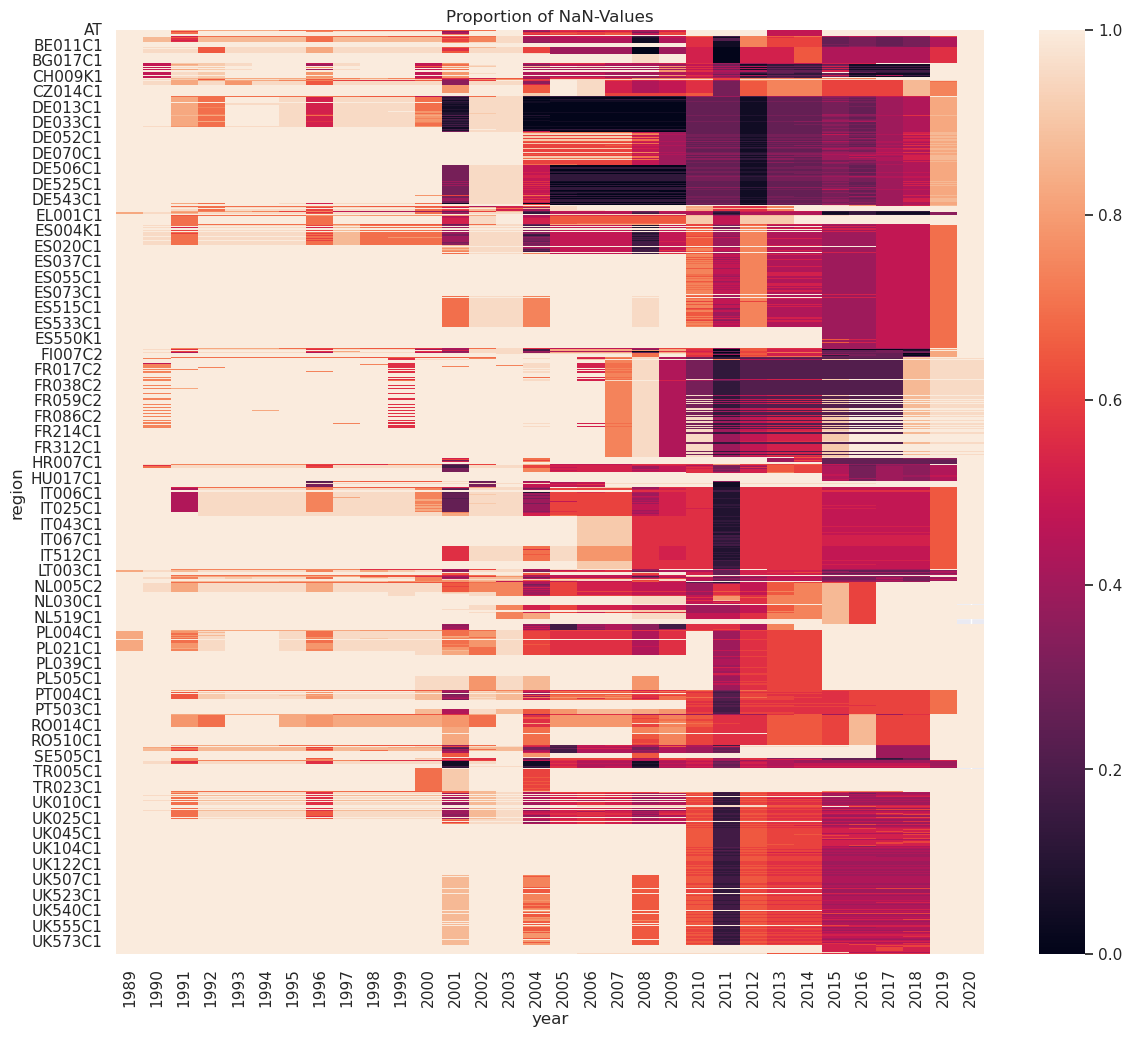

In [50]:
plt.figure(figsize = (14,12))
nan_country_year = df_eurostat_urban.isna().sum(axis=1).unstack(level=0)/df_eurostat_urban.shape[1]
ax = sns.heatmap(nan_country_year)
ax.set_title("Proportion of NaN-Values")
plt.show()

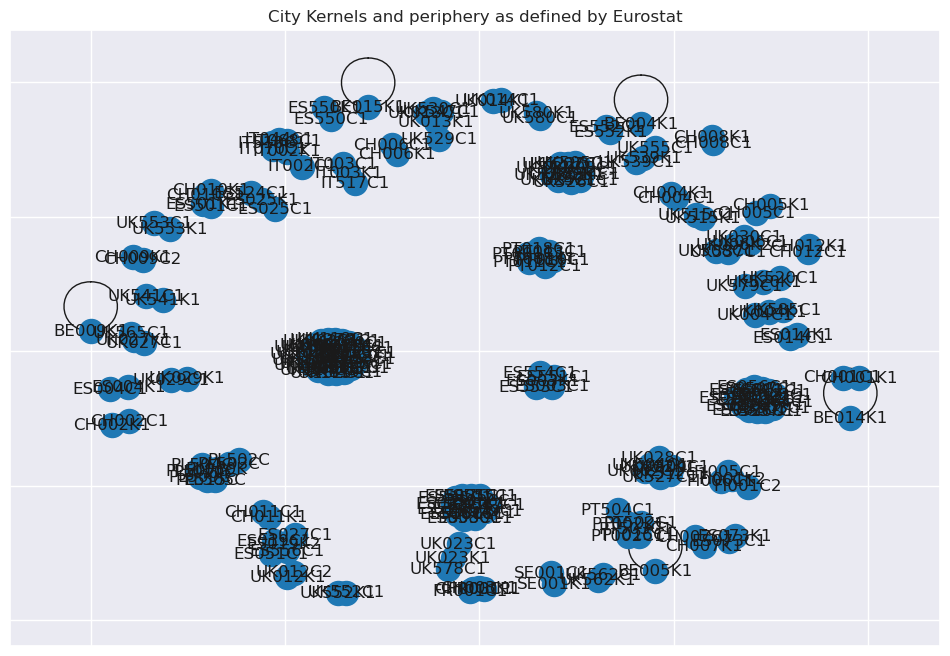

In [51]:
#NETWORK ANALYSIS: WIE IST DER DATENSATZ STRUKTURIERT
with open("data/geo/city_kernels.json","r") as f:
    ct_kernels = json.load(f)
    
fig,ax = plt.figure(figsize=(12,8)),plt.axes()
graph = nx.Graph()

graph.add_edges_from([(a,b) for a,b in ct_kernels.items()])
nx.draw_networkx(graph,ax=ax)
ax.set_title("City Kernels and periphery as defined by Eurostat")
plt.show()
# CONCLUSIO: VIELE KERNEL/PERIPHERIE KOMBINATIONEN -> BESSER AUF MAP PLOTTEN 

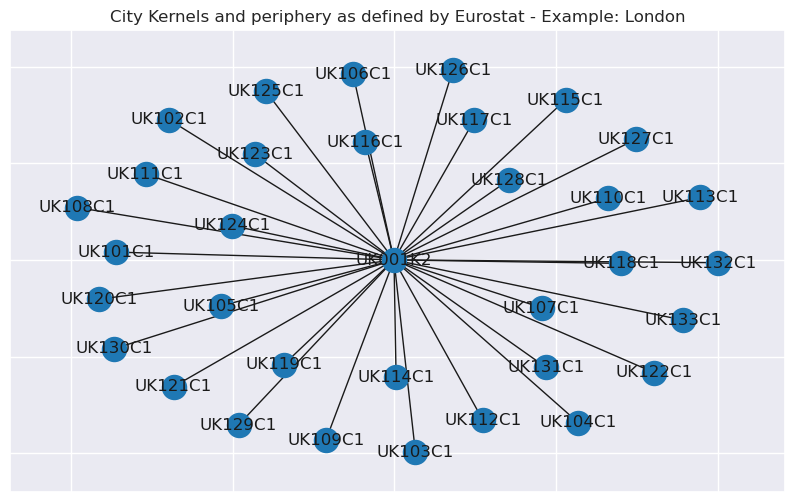

In [52]:
#IN DETAIL FOR LONDON
fig,ax = plt.figure(figsize=(10,6)),plt.axes()
graph = nx.Graph()

graph.add_edges_from([(a,b) for a,b in ct_kernels.items() if b == "UK001K2"])
nx.draw_networkx(graph,ax=ax)
ax.set_title("City Kernels and periphery as defined by Eurostat - Example: London")
plt.show()

In [181]:
#STATIC NETWORK MAP: CITIES AND THEIR KERNELS
with open("data/geo/city_network.json","r") as f:
    ct_net = json.load(f)
with open("data/geo/URAU_LB_2020_4326.geo.json","r",encoding="utf-8") as f:
    ct_geo = json.load(f)
with open("data/geo/city_kernels.json","r") as f:
    ct_kernels = json.load(f)

def html_from_dict(d:dict):
    """
    Makes an HTML string that formats a dict.
    params: d: Dictionary object
    returns: HTML str
    """
    html = ""
    for k,v in d.items():
        html += "<b>{}</b>: {} </br>".format(k,v)
    return html
    
def net_handler(**kwargs):
    #print(locals())
    msg = widgets.HTML(html_from_dict(kwargs["feature"]["properties"]))
    pop = Popup(location = kwargs["feature"]["geometry"]["coordinates"][::-1],child =msg)
    m4.add_layer(pop)
    
#FILTERN AUF NUR STÄDTE, WELCHE KERNEL SIND ODER EINEM KERNEL ZUGEORDNET SIND
kp_cts = list(set(ct_kernels.keys()) | set(ct_kernels.values()))
ct_geo_data = filter_geo("FID",kp_cts,ct_geo)

ct_geojson = GeoJSON(data = ct_geo_data)
ct_geojson.on_click(net_handler)

m4 = Map(center=(51.5,0),zoom=9)
#ADD NODES
m4.add_layer(ct_geojson)
#ADD EDGES
for edge in ct_net:
    m4.add_layer(Polyline(locations = edge))

display(m4)
#Only cities which are art of a network (have a kernel or are a kernel)

Map(center=[51.5, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [182]:
#INTERACTIVE NETWORK EXPLORATION: CITIES AND THEIR KERNELS - MAP
with open("data/geo/URAU_LB_2020_4326.geo.json","r",encoding="utf-8") as f:
    ct_geo = json.load(f)
with open("data/geo/city_kernels.json","r") as f:
    ct_kernels = json.load(f)
with open("data/geo/city_network.json","r") as f:
    ct_net = json.load(f)

def common_keys(df,geojson,on_lvl=1):
    """
    Return a list of keys (region codes) which are in df and geojson.
    params:
    - df: DataFrame; keys are index on level on_level; default = 1
    - gejson: Dict in GeoJSON format
    """
    geo_entities = []
    for d in geojson["features"]:
        geo_entities.append(d["properties"]["FID"])
    common = list(set(geo_entities) & set(df.index.get_level_values(on_lvl)))
    return common

def make_net(point):
    """
    Return all edges of the network containing a point (node) with coordinates [x,y] on the map
    params: point: Iterable of coordinates; e.g. [x,y]
    return: list of coordinates (points or nodes) connected to param: point
    """
    with open("data/geo/city_network.json","r") as f:
        ct_net = json.load(f)
    lines = []
    for edge in ct_net:
        if point in edge:
            lines.append(Polyline(locations = edge))
    return lines

def click_handler_net(**kwargs):
    #print(locals())
    remove_elements(m5,elem_type=Polyline)
    loc = kwargs["coordinates"]
    lines = make_net(loc)
    for line in lines:
        m5.add_layer(line)

#CITIES WHICH ARE IN EUROSTAT_EU AND GEOJSON DATA
ccts = common_keys(df_eurostat_urban,ct_geo)
ccts_geo = filter_geo("FID",ccts,ct_geo)

m5 = Map(center = (49.15,12.35),zoom=4)
markers = []
for d in ccts_geo["features"]:
    loc = d["geometry"]["coordinates"][::-1]
    pop = widgets.HTML(html_from_dict(d["properties"]))
    markers.append(Marker(location = loc,popup=pop,draggable=False))

for marker in markers:
    marker.on_click(click_handler_net)
    
marker_cluster = MarkerCluster(markers = tuple(markers))
m5.add_layer(marker_cluster)
display(m5)
#Conclusio: Dimension reduction with aggregation on kernels possible?

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [183]:
#FEATURE ENGINEERING #1
#NEW FEATURES - AGGREGATION ON KERNELS
with open("data/geo/city_area.json","r") as f:
    ct_area = json.load(f)
with open("data/geo/country_area.json","r") as f:
    country_area = json.load(f)
area = ct_area.copy()
area.update(country_area)   
    
l = []
for k,v in ct_kernels.items():
    l.append(k)
    l.append(v)

ids = pd.IndexSlice
df = df_eurostat_urban.copy()
#NEUE SPALTEN
df["country"] = list(map(lambda x: x[:2],df.index.get_level_values(1)))
df["kernel"] = list(map(lambda x:ct_kernels[x] if x in ct_kernels.keys() else x,df.index.get_level_values(1)))
df["area sqm"] = list(map(lambda x: area[x] if x in area.keys() else np.nan,df.index.get_level_values(1)))

#CONCLUSIO: Kernel Stätde sind eigenständige Einheiten. Man könnte also auf der kernel Spalte groupen und so
# die Werte aller Peripherie Städte in ihrem jeweiligen kernel entsprechen aggregieren (addieren/mittelwert).

In [184]:
# AGGREGATION ON KERNELS
aggs = {"sum":[],"mean":[]}
funcs = {}
for col in df.columns:
    func = "sum"
    f = np.sum
    if any(c in col for c in ["%","quote","EUR","je"]) and is_numeric_dtype(df[col]):
        func = "mean"
        f = np.mean
    aggs[func].append(col) 
    funcs[col] = f

df_grouped1 = df.groupby(by = ["year","kernel"])[aggs["sum"]].sum(min_count=1) #min_count = 1 needs to be passed, else sum(nan) ->0.0
df_grouped2 = df.groupby(by=["year","kernel"])[aggs["mean"]].mean()

df_agg = df_grouped1.merge(df_grouped2,how="left",left_index=True,right_index=True)
df_agg.drop(["kernel","country"],axis=1,inplace=True)
#Conclusio: Dimensionsreduktion ~34.500 -> 29.600 rows

In [185]:
#BEISPIEL Wien
df_agg.loc[ids[:,"AT001C1"],:].head()

,,"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt","Erwerbsbevölkerung, insgesamt","Erwerbslose, insgesamt","Bevölkerung am 1. Januar, insgesamt","Bevölkerung am 1. Januar, männlich","Bevölkerung am 1. Januar, weiblich",Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km,Zugelassene Privat-Pkw,Bei Straßenverkehrsunfällen getötete Personen,"Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt",...,Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %,"Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %",Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %,Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %,Preis einer kombinierten Monatskarte (alle öffentlichen Verkehrsmittel) für Fahrten ins Stadtzentrum von 5 bis 10 km - EUR,Preis einer Taxifahrt aus einer Entfernung von 5 km in das Stadtzentrum (tagsüber) - EUR,Zugelassene Pkw je 1000 Einwohner,Bei Straßenverkehrsunfällen getötete Personen je 10 000 Einwohner
year,kernel,,,,,,,,,,,,,,,,,,,,,
1989,AT001C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,AT001C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,AT001C1,NaN,NaN,NaN,1539848.0,714525.0,825323.0,NaN,461363.0,NaN,NaN,...,41.44,NaN,NaN,1.01,15.28,NaN,NaN,NaN,299.62,NaN
1992,AT001C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,AT001C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
#DISTRUBUTION OF FEATURES (avg. 1990-2018) AND % NOT NAN VALUES

def plot_hist(feature,y_range:tuple,log=False):
    start,stop = y_range[0],y_range[1]
    cities = [ct for ct in df_agg.index.get_level_values(1).unique() if len(ct) >2] #nur städte
    df_ = df_agg.loc[ids[start:stop,cities],:].groupby(by="kernel").mean()
    df_av_= df_agg.loc[ids[start:stop,cities],:].groupby("kernel").agg(lambda x: x.count()/len(x))
    
    fig,axs = plt.subplots(figsize=(12,5),ncols=2,gridspec_kw={'width_ratios': [3, 1]})
    try:
        data = df_.dropna(axis=0)[feature]
        sns.histplot(data = data,ax=axs[0],label="histogram")
        ax01 = axs[0].twinx()
        sns.ecdfplot(data=data,ax=ax01,color="black",label="cum. distribution")
    except ValueError as e:
        print(e)
    #available data
    sns.histplot(data=df_av_[feature],color="tab:red",kde=False,ax=axs[1])    
    
    if log:
        axs[0].set_yscale("log")
    
    axs[0].set_title("Distribution of {} (avg. over {}-{})".format(feature,start,stop))
    axs[1].set_title("Available Data %")
    axs[1].set_xlabel(" ")
    ax01.legend()
    plt.tight_layout()
    plt.show()
    
fdrop = widgets.Dropdown(options=list(df_agg.columns))
y_range = widgets.IntRangeSlider(value= (1990,2018),min=1990,max=2018,continuous_update=False)
log_c = widgets.Checkbox(value=False,description="log")
display(widgets.HBox([fdrop,y_range]),log_c)

out12 = interactive_output(plot_hist,{"feature":fdrop,"y_range":y_range,"log":log_c});

out12

#Anm. available data: Distribution of percentage of datapoints reported by each city (= num. of years reported/28years)
#Conclusio: In Detail Analyse der Verteilungen in Part Regression Analysis (inkl.scatter und Co.);

Checkbox(value=False, description='log')

Output()

In [187]:
#AVERAGE OF CITIES IN EACH COUNTRY
cities = [ct for ct in df_agg.index.get_level_values(1).unique() if len(ct) >2] #nur Städte
df_c_  = df_agg.loc[ids[:,cities],:].copy()
df_c_["country"] = list(map(lambda x: x[:2],df_c_.index.get_level_values(1)))
n_cts = {country:len(df_c_.loc[ids[2010,df_c_["country"]==country],:]) for country in df_c_["country"].unique()}
df_c_["n_cities"] = list(map(lambda x: n_cts[x],df_c_["country"].values))

def plot_city_avg_p_cnty(feature,log=False,data=df_c_,**kwargs):
    fig,ax =  plt.figure(figsize=(12,6)),plt.axes()
    order=data.groupby("country").mean().sort_values(feature).index.get_level_values(0)
    sns.barplot(x="country", y=feature,data=data,log=log,ax=ax,color="tab:blue",capsize=.25,order=order,**kwargs)
    #sns.boxplot(x="country", y=feature,data=data,ax=ax,color="tab:blue")
  
    ax.set_title("Avg. number of "+feature+" in all cities per country")
    plt.ylabel("Count")
    plt.show()
    #print(n_cts)
    
feat_d = widgets.Dropdown(options = [col for col in df_c_.columns if is_numeric_dtype(df_c_[col])]);
interact(plot_city_avg_p_cnty,feature=feat_d,data=fixed(df_c_));

#Conclusio: Unexpected Outlier in HU, Verkehrsmittel

interactive(children=(Dropdown(description='feature', options=('Studierende an Hochschuleinrichtungen (ISCED-S…

Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %  \
year kernel                                                        
2001 HU001C1                                           221139.0    
     HU002C1                                            14271.0    
     HU003C1                                            16191.0    
     HU004C1                                            19429.0    
     HU005C1                                            22418.0    
     HU006C1                                            15683.0    
     HU007C1                                            17404.0    
     HU008C1                                            14702.0    
     HU009C1                                            14912.0    

              Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %  \
year kernel                                                                                                                     
2001 HU001C1                                                NaN                                                                 
     HU002C1                                                NaN                                                                 
     HU003C1                                                NaN                                                                 
     HU004C1                                                NaN                                                                 
     HU005C1                                                NaN                                                                 
     HU006C1                                                NaN                                                                 
     HU007C1                                                NaN                                                                 
     HU008C1                                                NaN                                                                 
     HU009C1                                                NaN                                                                 

              Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %  \
year kernel                                                             
2001 HU001C1                                             7425.0         
     HU002C1                                              359.0         
     HU003C1                                             3056.0         
     HU004C1                                              740.0         
     HU005C1                                             4445.0         
     HU006C1                                             6835.0         
     HU007C1                                             7767.0         
     HU008C1                                             8070.0         
     HU009C1                                             2913.0         

              Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %  \
year kernel                                                            
2001 HU001C1                                                NaN        
     HU002C1                                                NaN        
     HU003C1                                                NaN        
     HU004C1                                                NaN        
     HU005C1                                                NaN        
     HU006C1                                                NaN        
     HU007C1                                                NaN        
     HU008C1                                                NaN        
     HU009C1                                                NaN        

              Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %  \
year kernel                                                              
2001 HU001C1                                            50713.0          
     HU002C1              

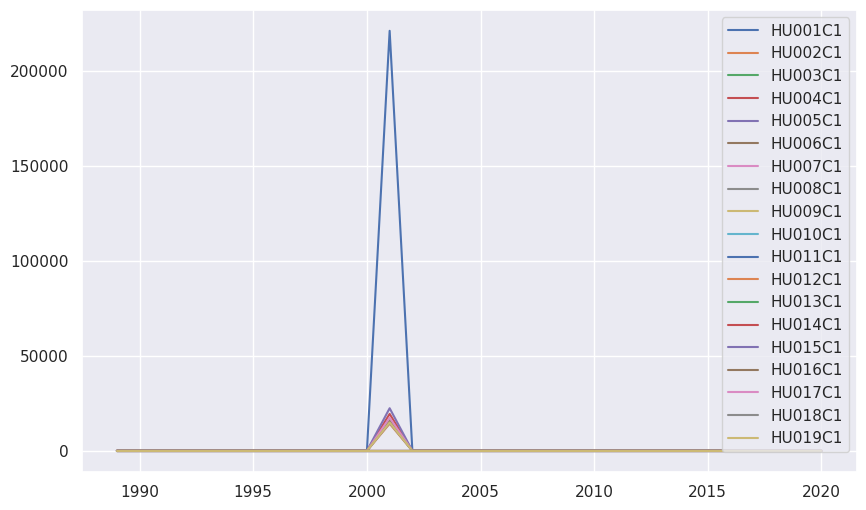

In [167]:
#OUTLIER INVESTIGATION FOR HUNGARY - Verkehrsmittel %
#STRATEGY: REPLACING OUTLIER
cols = [col for col in df.columns if "%" in col]
display(df_c_.loc[df_c_["Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %"]>100,cols])

fig,ax=plt.figure(figsize=(10,6)),plt.axes()

df_hu = df_c_.loc[ids[:,df_c_["country"]=="HU"],"Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %"]
x = list(df_hu.index.get_level_values("year").unique())
for ct in df_hu.index.get_level_values("kernel").unique():
    y = df_hu.loc[ids[:,ct]].fillna(0).values
    ax.plot(x,y,label=ct)
plt.legend()
plt.show()

#Coclusio: Outliers in HU in the year 2001 remain unexplained and will be reset to np.nan

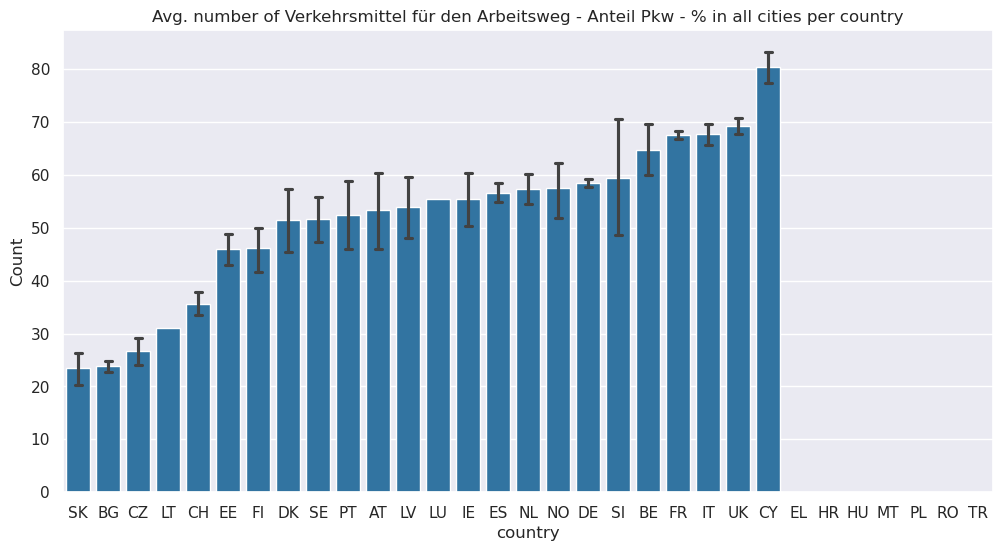

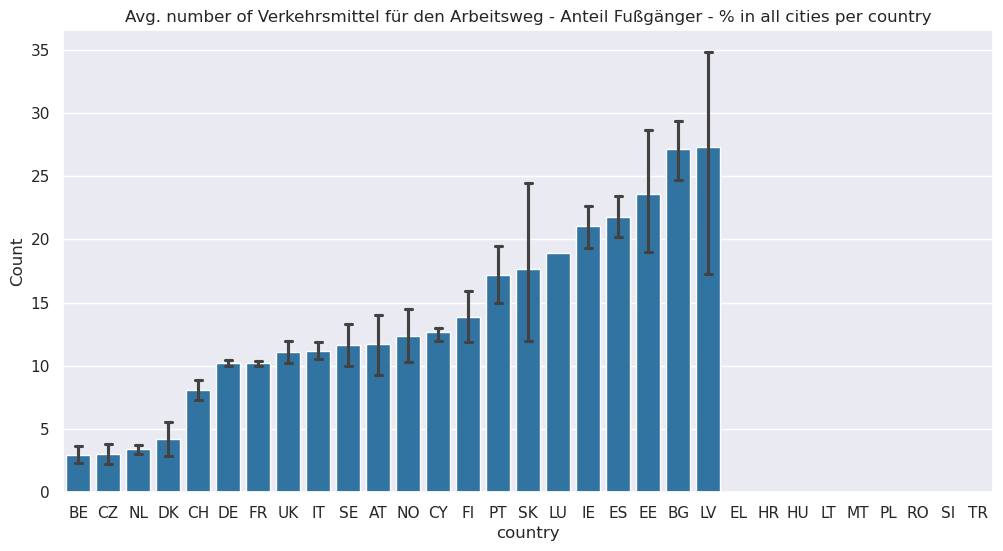

In [168]:
#REPLACING OUTLIERS IN HUNGARY
df_cities = df_c_.copy()
df_cities.loc[(2001,df_cities["country"]=="HU"),cols] = np.nan

plot_city_avg_p_cnty("Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %",data=df_cities)
plot_city_avg_p_cnty("Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %",data=df_cities)
#Conclusio:Möglichee Cluster: 3-4 Plateaus für "Anteil PKW%"

#df_cities.to_pickle("data/pickle/df_cities.pkl")

In [188]:
#AVERAGE FEATURE VALUES 1990-2010 per CITY and DETAIL ANALYSIS 
with open("data/geo/URAU_LB_2020_4326.geo.json","r",encoding="utf-8") as f:
    ct_geo = json.load(f)
#with open("data/geo/city_locs.json","r") as f:
#    city_loc = json.load(f)

df_cities = pd.read_pickle("data/pickle/df_cities.pkl")
df_cities.drop("country",axis=1,inplace=True)

#CUSTOM LEGEND CLASS
class CircleLegend:
    """
    A legend for circle markers: Builds a legend with n (default n=5) circles for a list of values.
    The max radius (scale) should be equal to the max marker radius (default scale=30).
    Accepts additional kwargs.
    """
    def __init__(self,values:list,n=5,scale=30,**kwargs):
        self.title = widgets.HTML('<h4 style="color:black;font-weight:lighter">Legend</h4>')
        legend = [self.title]
        vmin,vmax = min(values),max(values)
        values = np.linspace(vmax,vmin,n)
        for v in values:
            legend.append(self.circle(self.radius(v,vmin,vmax,scale),int(v),**kwargs))
        box = widgets.VBox(legend,layout = Layout(align_items="center"))
        self.legend = WidgetControl(widget=box,**kwargs)
            
    def radius(self,v,vmin,vmax,scale):
        return scale*v / (vmax-vmin)
    
    def circle(self,r,v,**kwargs):
        c_style = 'height: {}px; width: {}px;background-color:#dadada;border-radius: 50%;margin-left:auto;margin-right:auto'.format(2*r,2*r)
        if "style" in kwargs.keys():
            if kwargs["style"] == "marker":
                c_style = 'height: {}px; width: {}px;background-color:#e6ebff;border-style:solid;border-width:thin;border-color:#73ABEE;border-radius: 50%;margin-left:auto;margin-right:auto'.format(2*r,2*r)
        l_style = 'text-align:center'
        circle = widgets.HTML('<div style= "{}"></div>'.format(c_style))
        label = widgets.HTML('<div style= "{}">{}</div>'.format(l_style,int(v)))
        return widgets.VBox([circle,label],layout = Layout(width="fit-content"))


def get_loc(city:str): #unused; used before for writing file city_locs.json 
    """
    Get a city's coordinates
    params:
    - city: A city's FID; e.g. "AT001C1"
    return: A pair of coordinates as list: [x,y] 
    """
    with open("data/geo/URAU_LB_2020_4326.geo.json","r",encoding="utf-8") as f:
        ct_pt = json.load(f)
    for c in ct_pt["features"]:
        if c["properties"]["FID"] == city:
            return c["geometry"]["coordinates"][::-1]
    return None


def radius(v,vmin,vmax,scale=30):
    return scale*v/(vmax-vmin)


def feature_plot(city,f1,f2,df):
    fig,axs = plt.subplots(figsize=(12,5),ncols=2,gridspec_kw={'width_ratios': [3, 2]})
    x = df.loc[ids[:,city],:].index.get_level_values("year")
    axs[0].plot(x,df.loc[ids[:,city],f1].values,color="tab:blue",label=f1)
    ax01 = axs[0].twinx()
    ax01.plot(x,df.loc[ids[:,city],f2].values,color="tab:red",label=f2)
    sns.scatterplot(data=df.loc[ids[:,city],:],x=f1,y=f2,ax=axs[1])
    axs[0].set_ylabel(f1)
    ax01.set_ylabel(f2)
    plt.tight_layout()
    fig.legend(loc = 'upper left')
    plt.show()

#MAP UI
m6 = Map(center=(49.15,12.35),zoom=4)
ids = pd.IndexSlice
#df_ct_avg = df_cities.loc[ids[:,city_loc.keys()],:].groupby("kernel").mean() #keep only cities with known coordinates
df_ct_avg = df_cities.groupby("kernel").mean()
f_drop = widgets.Dropdown(options = list(df_ct_avg.columns))

#GUI UNTER MAP
d1 = widgets.Dropdown(options = list(df_ct_avg.columns))
d2 = widgets.Dropdown(options = list(df_ct_avg.columns))

#callback funktion um die cricles mit berechnetem radius zu stylen
def circle_styler(col,feature):
    city = feature["properties"]["FID"]
    vmin,vmax= df_ct_avg.loc[:,col].min(),df_ct_avg.loc[:,col].max()
    v = df_ct_avg.loc[city,col]
    r = radius(v,vmin,vmax)
    return {"radius":r}

#callback für highest layer dropdown handler
def geo_circle_handler(col,m):
    remove_elements(m,GeoJSON)
    remove_elements(m,Popup)
    remove_controls(m,ctrl_type=WidgetControl)

    style = {"radius":0,"weight": 1,"opacity": 1,"fillOpacity": 0.2} 
    df_ = df_ct_avg.loc[df_ct_avg[col].notna(),col]
    cities = list(df_.index.get_level_values("kernel").unique())
    geo_data = filter_geo("FID",cities,ct_geo)
    geojson = GeoJSON(data=geo_data,point_style=style,style_callback = partial(circle_styler,col)) #pass additional arguments to callback function
    geojson.on_click(partial(geo_circle_click,m,col)) #pass additional args m,col zu callback function
    
    lobj =  CircleLegend(values=df_.values,n=4,position="bottomright",style="marker")
    
    m.add_layer(geojson)
    m.add_control(lobj.legend)

#callback für geojson on_click event
def geo_circle_click(m,col,**kwargs):
    loc = kwargs["feature"]["geometry"]["coordinates"][::-1]
    city = kwargs["feature"]["properties"]["FID"]
    v = df_ct_avg.loc[city,col]
    pop = widgets.HTML("<b>{}</b>: {}".format(city,int(v)))
    popup = Popup(location = loc,child = pop)
    m.add_layer(popup)

    lower_gui(**kwargs)
    
def lower_gui(**kwargs): #gui unter map
    out8.clear_output()
    ct = kwargs["id"]
    ct = kwargs["properties"]["FID"]
    
    graph = interactive_output(feature_plot,{"city":fixed(ct),"f1":d1,"f2":d2,"df":fixed(df_cities)})
    
    with out8:
        display(ct)
        display(widgets.HBox([d1,d2]))
        display(graph)

out8 = widgets.Output()

interact(geo_circle_handler,col=f_drop,m=fixed(m6))
display(m6)
out8

#CONCLUSIO: Viele NaNs für Städte -> further aggregation, Mehr in Mssing Data Handling
# Interesting Example: London: Verkehrsmittel PKW. Center London 31%, Peripherie ~60% | Öffentlich umgekehrt
# TODO: NEUE SPALTE POP DENSITY BERECHNEN - vllt. Korrelation mit anteil auto/fußgänger usw.

interactive(children=(Dropdown(description='col', options=('Studierende an Hochschuleinrichtungen (ISCED-Stufe…

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Output()

In [190]:
#MAP UI
warnings.filterwarnings("ignore",category=UserWarning)

df_urban_missing = pd.read_pickle("data/pickle/df_urban_missing.pkl")
    
m7 = Map(center=(49.15,12.35),zoom=4)
ids = pd.IndexSlice
ft_drop = widgets.Dropdown(options = list(df_urban_missing.columns))
ysld = widgets.IntSlider(value=2014,min = 1990,max = 2018,continuous_update=False)

#callback funktion um die cricles mit berechnetem radius zu stylen
def circle_styler_year(col,year,feature):
    city = feature["properties"]["FID"]
    vmin,vmax= df_urban_missing.loc[:,col].min(),df_urban_missing.loc[:,col].max()
    v = df_urban_missing.loc[ids[year,city],col]
    r = radius(v,vmin,vmax)
    return {"radius":r}

#callback für geojson on_click event
def geo_circle_click_year(m,col,year,**kwargs):
    loc = kwargs["feature"]["geometry"]["coordinates"][::-1]
    city = kwargs["feature"]["properties"]["FID"]
    v = df_urban_missing.loc[ids[year,city],col]
    pop = widgets.HTML("{} </br> <b>{}</b>: {}".format(year,city,int(v)))
    popup = Popup(location = loc,child = pop)
    m.add_layer(popup)

#callback für highest layer dropdown handler
def geo_circle_handler_year(col,m,year):
    remove_elements(m,GeoJSON)
    remove_elements(m,Popup)
    
    style = {"radius":0,"weight": 1,"opacity": 1,"fillOpacity": 0.2} 
    df_ = df_urban_missing.loc[year,col]
    cities = list(df_.index.get_level_values("kernel").unique())
    geo_data = filter_geo("FID",cities,ct_geo)
    geojson = GeoJSON(data=geo_data,point_style=style,style_callback = partial(circle_styler_year,col,year)) #pass additional arguments to callback function
    geojson.on_click(partial(geo_circle_click_year,m,col,year)) #pass additional args m,col zu callback function
    m.add_layer(geojson)
    
    
interact(geo_circle_handler_year,col=ft_drop,year = ysld,m=fixed(m7))
m7
#EVTL. TODO: ADD CUSTOM LEGEND

interactive(children=(Dropdown(description='col', options=('Studierende an Hochschuleinrichtungen (ISCED-Stufe…

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [172]:
#CORRELATION ANALYSIS
irel = ['Bevölkerung am 1. Januar, männlich',
       'Bevölkerung am 1. Januar, weiblich',
        'Erwerbsbevölkerung, insgesamt',
        'Erwerbslose, insgesamt',
        'area sqm','Bei Straßenverkehrsunfällen getötete Personen','country', 'n_cities',
       'Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt','Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt',
       'Bevölkerung im Alter von 65+ Jahren, insgesamt']
corr = df_urban_missing.drop(labels=irel,axis=1).groupby("year").mean().corr()
display(corr.style.background_gradient(cmap="viridis"))
#Conclusio: ein paar interessante Korrelationen als Beisiele für pdf 

,"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt","Bevölkerung am 1. Januar, insgesamt",Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km,Zugelassene Privat-Pkw,Erwerbslosenquote,Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %,"Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %",Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %,Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %,Preis einer kombinierten Monatskarte (alle öffentlichen Verkehrsmittel) für Fahrten ins Stadtzentrum von 5 bis 10 km - EUR,Preis einer Taxifahrt aus einer Entfernung von 5 km in das Stadtzentrum (tagsüber) - EUR,Zugelassene Pkw je 1000 Einwohner,Bei Straßenverkehrsunfällen getötete Personen je 10 000 Einwohner
"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt",1.000000,0.282536,0.021283,0.612273,0.227711,-0.289726,0.664424,0.175988,-0.036086,-0.045926,-0.265722,-0.199821,-0.164228,0.175457,0.688247
"Bevölkerung am 1. Januar, insgesamt",0.282536,1.000000,-0.286118,0.735604,0.238369,0.109074,-0.139914,0.516208,-0.198009,0.220500,0.418054,-0.190221,0.065795,-0.409052,0.036636
Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km,0.021283,-0.286118,1.000000,-0.208101,-0.403972,-0.077521,0.161681,-0.389343,0.071480,0.167634,-0.228310,-0.134196,-0.006488,-0.402920,0.168114
Zugelassene Privat-Pkw,0.612273,0.735604,-0.208101,1.000000,0.321697,-0.189286,0.385870,0.162418,-0.297255,0.263415,-0.039284,0.030980,-0.002723,0.256522,-0.349743
Erwerbslosenquote,0.227711,0.238369,-0.403972,0.321697,1.000000,0.684644,-0.447009,0.095415,-0.271109,-0.049451,0.411570,0.346342,-0.132076,0.241929,-0.393663
Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %,-0.289726,0.109074,-0.077521,-0.189286,0.684644,1.000000,-0.738103,0.050946,-0.141752,-0.150525,0.358316,0.318754,0.080622,0.111552,-0.136786
"Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %",0.664424,-0.139914,0.161681,0.385870,-0.447009,-0.738103,1.000000,-0.013719,0.054816,-0.091882,-0.656692,0.343787,-0.127969,0.371940,-0.217203
Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %,0.175988,0.516208,-0.389343,0.162418,0.095415,0.050946,-0.013719,1.000000,-0.212891,0.035924,0.217253,-0.144234,-0.209529,-0.395976,-0.015136
Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %,-0.036086,-0.198009,0.071480,-0.297255,-0.271109,-0.141752,0.054816,-0.212891,1.000000,-0.616013,-0.191243,0.199500,-0.060697,-0.158789,-0.126770
Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %,-0.045926,0.220500,0.167634,0.263415,-0.049451,-0.150525,-0.091882,0.035924,-0.616013,1.000000,0.162235,-0.393443,0.412365,-0.147492,0.199011


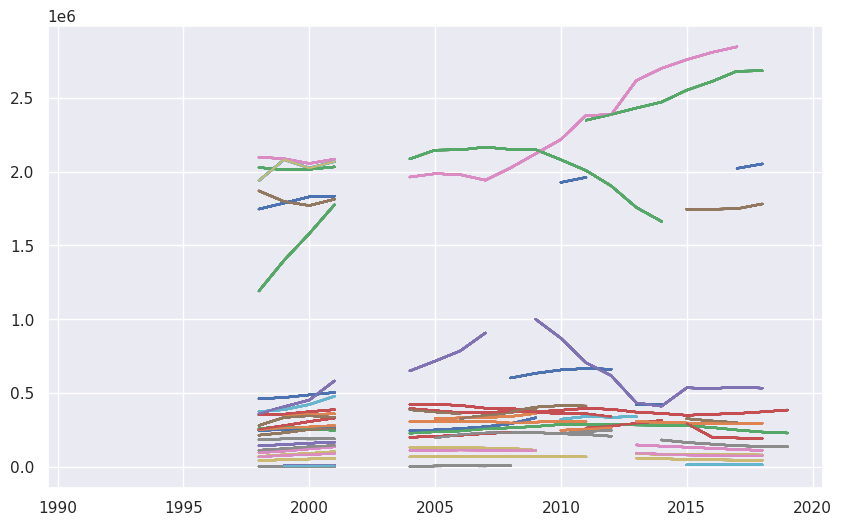

In [65]:
#AUF LÄNDEREBENE TREND FÜR MISSING DATA HANDLING ERKENNBAR?

fig,ax = plt.figure(figsize=(10,6)),plt.axes()
feature = "Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt"
countries = [c for c in df_agg.index.get_level_values("kernel") if len(c)==2]
obs = len(countries)
for country in countries:
    df_ = df_agg.loc[ids[:,country],:]
    x = df_.index.get_level_values("year").unique()
    y = df_.loc[ids[:,country],feature].values
    ax.plot(x,y)
    #df_agg.loc[ids[1990:2018,country],feature].plot(ax=ax)
plt.show()

## UN ECE

In [66]:
df_unece.columns

Index(['Area (square kilometres)', 'Total population',
       'Population density, pers. per sq. km', 'Population aged 0-14, male',
       'Population aged 0-14, female', 'Population aged 15-64, male',
       'Population aged 15-64, female', 'Population aged 65+, male',
       'Population aged 65+, female', 'Total population, male (%)',
       'Total population, female (%)', 'Life expectancy at birth, women',
       'Life expectancy at birth, men', 'Life expectancy at age 65, women',
       'Life expectancy at age 65, men', 'Total fertility rate',
       'Adolescent fertility rate',
       'Mean age of women at birth of first child',
       'Computer use, 16-24, male', 'Computer use, 16-24, female',
       'Computer use, 25-54, male', 'Computer use, 25-54, female',
       'Computer use, 55-74, male', 'Computer use, 55-74, female',
       'Women in the Labour Force, Percent of corresponding total for both sexes',
       'Female part-time employment, percent of both sexes',
       'Gende

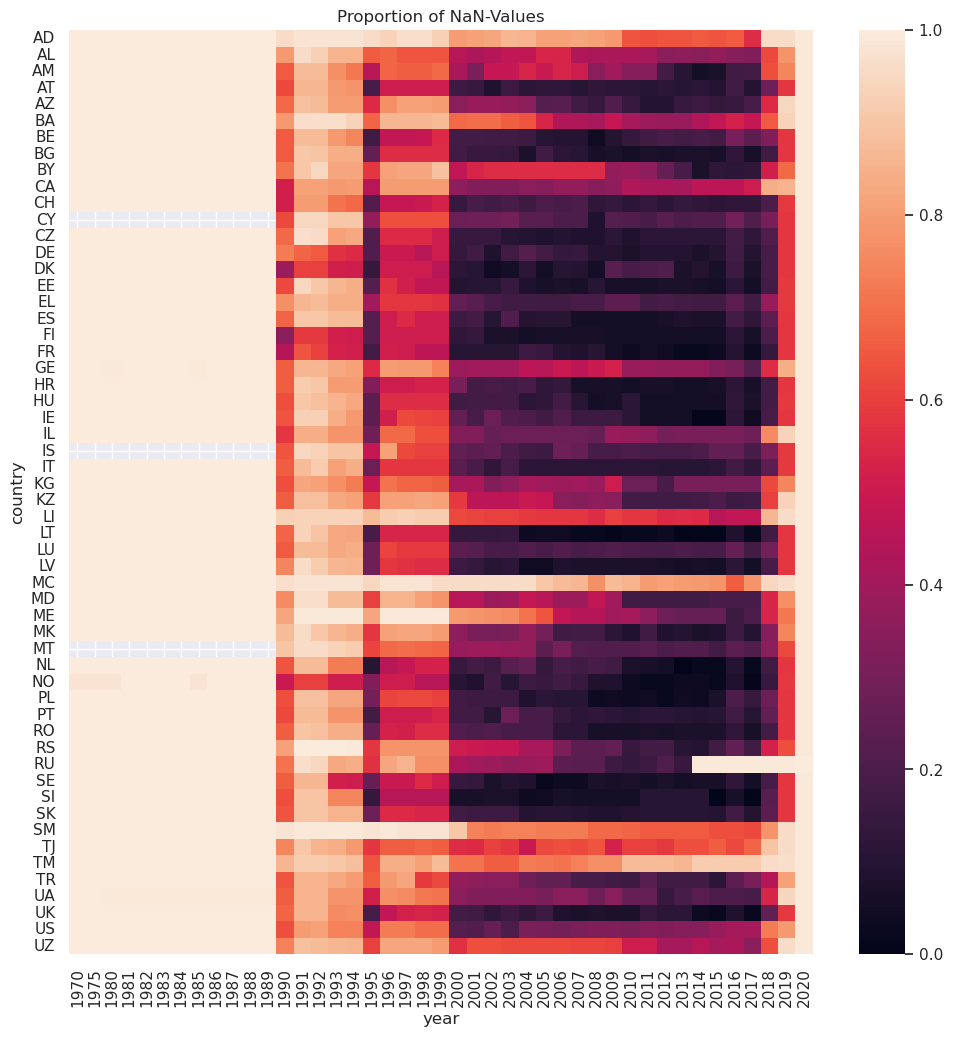

In [330]:
plt.figure(figsize = (12,12))
nan_country_year = df_unece.isna().sum(axis=1).unstack(level=0)/df_unece.shape[1]
ax = sns.heatmap(nan_country_year)
ax.set_title("Proportion of NaN-Values")
plt.show()

In [173]:
#SELECTED COLUMNS FROM UNECE
columns = ['Area (square kilometres)', 
           'Total population',
           'Unemployment rate',
           'GDP per capita at current prices and PPPs, US$',
           'Purchasing power parity (PPP), NCU per US$',
           'Consumer price index, growth rate',
           'Passengers Total Passenger kilometres (millions)']

#BARPLOT
df_unece_red = df_unece[columns]
countries = df_unece_red.index.get_level_values(1).unique()
years = [int(y) for y in df_unece_red.index.get_level_values(0).unique()]

grid = CheckboxGrid(countries)
box_ui = grid.ui
kwargs = grid.kwargs

slider_ui = widgets.IntSlider(value = 2010, min = min(years), max = max(years),continuous_update=False)
kwargs["y_slider"] = slider_ui

scale_box = widgets.RadioButtons(options = [("MinMax Scaler",True),("Absolute",False)])
kwargs["rescale"] = scale_box

sel_ui = widgets.HBox([slider_ui,scale_box])

selected = []
def un_ece_handler(**kwargs):
    #AGGREGATE USER INPUT
    selected.clear()
    year = kwargs["y_slider"]
    rescale = kwargs.pop("rescale")
    for key in kwargs:
        if kwargs[key] == True:
            selected.append(key)

    #DO SOMETHING
    bar(year,selected,data=df_unece_red,rescale=rescale)

out = interactive_output(un_ece_handler,kwargs)
display(box_ui,sel_ui,out)

Box(children=(Checkbox(value=False, description='AL', layout=Layout(margin='0px', padding='0px', width='25%'))…

Output()

In [174]:
countries = df_unece.index.get_level_values(1).unique()
years = df_unece.index.get_level_values(0).unique()

attributes = df_unece.columns

cb_grid = CheckboxGrid(countries)
cb_ui = cb_grid.ui
kwargs = cb_grid.kwargs

attr_ui = widgets.Dropdown(options = attributes)
range_ui = widgets.IntRangeSlider(value = (1990,2018),min =min(years) ,max = max(years),continuous_update=False)

kwargs["attr"] = attr_ui
kwargs["d_range"] = range_ui
kwargs["data"] = fixed(df_unece)

b = widgets.HBox([attr_ui,range_ui])

selected = [] #instantiate an empty list that saves the selected countries in linehandler(**kwargs)

out6 = interactive_output(line_handler,kwargs)
display(cb_ui,b,out6)

# Consumer price index growth rate Kroation: peek in 1990 ist real! -> deshalb median in missing data handling
# BG 1997;

Box(children=(Checkbox(value=False, description='AL', layout=Layout(margin='0px', padding='0px', width='25%'))…

Output()

## Gapminder

In [77]:
df_gapminder.columns

Index(['cars_trucks_and_buses_per_1000_persons',
       'income_per_person_gdppercapita_ppp_inflation_adjusted',
       'price_usd_gasoline', 'railway_passenger_mio_km',
       'railway_total_mio_km', 'roads_paved_percent_of_total_roads',
       'traffic_deaths_per_100000_people'],
      dtype='object')

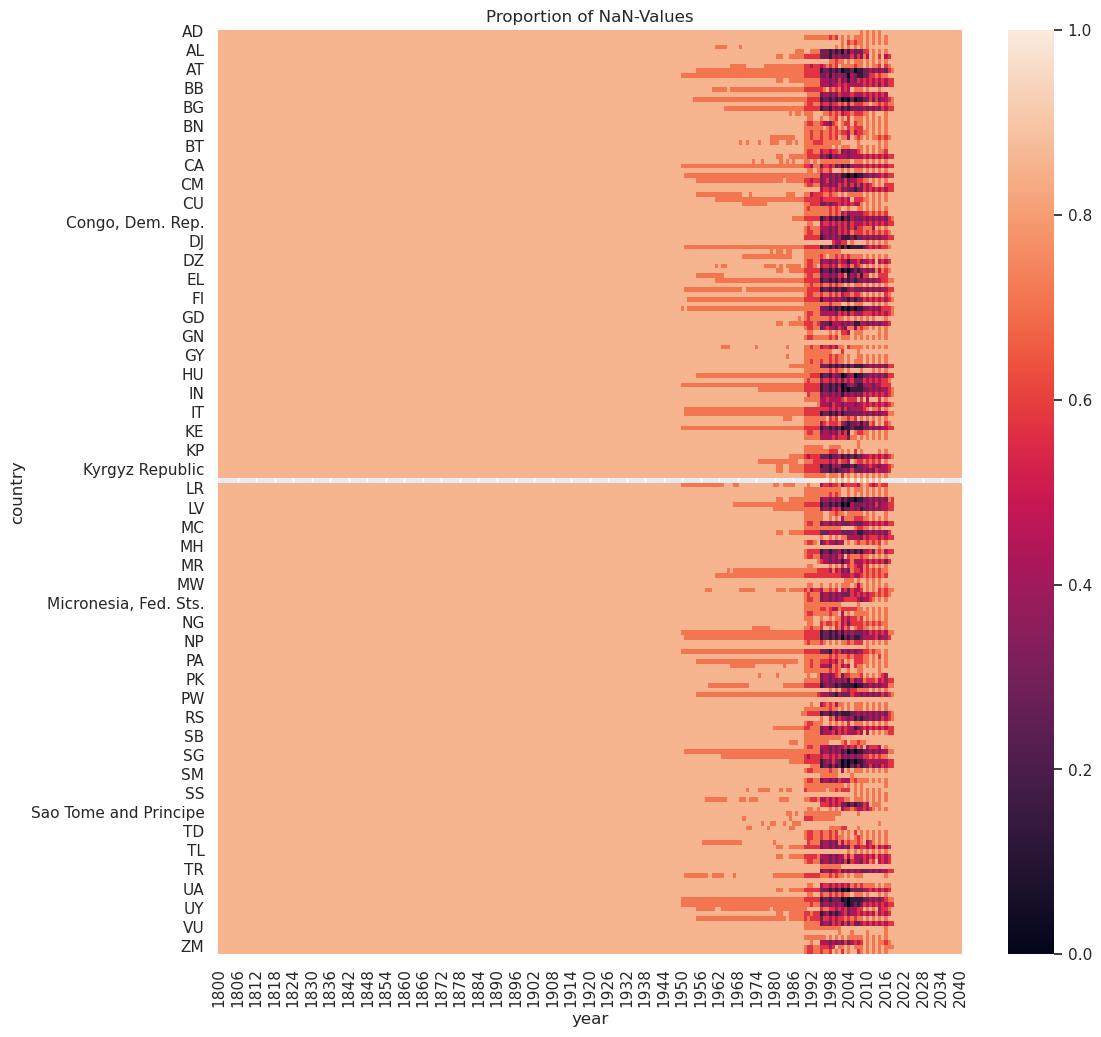

In [333]:
plt.figure(figsize = (12,12))
nan_country_year = df_gapminder.isna().sum(axis=1).unstack(level=0)/df_gapminder.shape[1]
ax = sns.heatmap(nan_country_year)
ax.set_title("Proportion of NaN-Values")
plt.show()

In [175]:
attributes = ['cars_trucks_and_buses_per_1000_persons',
       'income_per_person_gdppercapita_ppp_inflation_adjusted',
       'price_usd_gasoline', 'railway_passenger_mio_km',
       'railway_total_mio_km', 'roads_paved_percent_of_total_roads',
       'traffic_deaths_per_100000_people']

un_c = df_unece.index.get_level_values(1).unique()
#nur für Länder, die auch in UN Datensatz sind; sonst zu viele
countries = [c for c in df_gapminder.index.get_level_values(1).unique() if c in un_c]
years = df_gapminder.index.get_level_values(0).unique()

cb_grid = CheckboxGrid(countries)
cb_ui = cb_grid.ui
kwargs = cb_grid.kwargs

attr_ui = widgets.Dropdown(options = attributes)
range_ui = widgets.IntRangeSlider(value = (1990,2010),min =min(years) ,max = max(years),continuous_update=False)

kwargs["attr"] = attr_ui
kwargs["d_range"] = range_ui
kwargs["data"] = fixed(df_gapminder)

b = widgets.HBox([attr_ui,range_ui])

selected = [] #instantiate an empty list that saves the selected countries in linehandler(**kwargs)

out7 = interactive_output(line_handler,kwargs)
display(cb_ui,b,out7)

#Conclusio: Nur gdp per capita verwendbar, da keine daten für gas price aus EU Ländern vorhanden
#Obseravtions: traffic deaths converge to ~ 5;

Box(children=(Checkbox(value=False, description='AL', layout=Layout(margin='0px', padding='0px', width='25%'))…

Output()

# Feature Engineering

## National Level

In [5]:
#FEATURE SELECTION BASED ON VISUALIZATION RESULTS AND AVAILABLE DATA
#3 CATEGORIES: TRAFFIC, SOCIO, ECONOMIC

df_eurostat_eu = pd.read_pickle("data/pickle/df_eurostat_eu.pkl")
df_gapminder = pd.read_pickle("data/pickle/df_gapminder.pkl")
df_unece = pd.read_pickle("data/pickle/df_unece.pkl")

start,end = 1990,2018
eu_cols = ['Busse Insgesamt Anzahl',
            'PKW pro Tausend Einwohner Anzahl',
            'Züge, Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent',
            'Züge Personenbeförderung Prozent',
            'Personenkraftwagen Personenbeförderung Prozent',
            'Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent',
            'Personenbeförderung Index, 2010=100']
un_cols = ['Area (square kilometres)', 
            'Total population',
            'Population aged 0-14, male',
            'Population aged 0-14, female', 
            'Population aged 15-64, male',
            'Population aged 15-64, female', 
            'Population aged 65+, male',
            'Population aged 65+, female',
            'Unemployment rate',
            'Purchasing power parity (PPP), NCU per US$',
            'Consumer price index, growth rate',
            'Passengers Total Passenger kilometres (millions)',
            'Passengers Total Number of passengers (1000s)',
            'Total length of railway lines (km)',
           'Total length of motorways (km)']
gap_cols = ['income_per_person_gdppercapita_ppp_inflation_adjusted']

ids = pd.IndexSlice
df_national = df_eurostat_eu.merge(df_unece,how="left",on=["year","country"]).merge(df_gapminder,how="left",on=["year","country"]).loc[ids[start:end,:],eu_cols+un_cols+gap_cols]

labels = ['Population aged 0-14, male',
            'Population aged 0-14, female', 
            'Population aged 15-64, male',
            'Population aged 15-64, female', 
            'Population aged 65+, male',
            'Population aged 65+, female']
    
df_national['Population aged 0-14'] = df_national['Population aged 0-14, male'] + df_national['Population aged 0-14, female']
df_national['Population aged 15-64'] = df_national['Population aged 15-64, male'] + df_national['Population aged 15-64, female']
df_national['Population aged 65+'] = df_national['Population aged 65+, male'] + df_national['Population aged 65+, female']

df_national.drop(labels = labels, axis = 1,inplace=True)
df_national.drop(labels = ['EU27_2020', 'EU28','EU27_2007'],axis=0,level=1,inplace=True)
df_national = df_national.astype(float)

df_national.drop(labels=["BA"],axis=0,level=1,inplace=True)

#df_national.to_pickle("data/pickle/df_national_missing.pkl")

In [6]:
df_national = pd.read_pickle("data/pickle/df_national_missing.pkl")
df_national.columns

Index(['Busse Insgesamt Anzahl', 'PKW pro Tausend Einwohner Anzahl',
       'Züge, Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent',
       'Züge Personenbeförderung Prozent',
       'Personenkraftwagen Personenbeförderung Prozent',
       'Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent',
       'Personenbeförderung Index, 2010=100', 'Area (square kilometres)',
       'Total population', 'Unemployment rate',
       'Purchasing power parity (PPP), NCU per US$',
       'Consumer price index, growth rate',
       'Passengers Total Passenger kilometres (millions)',
       'Passengers Total Number of passengers (1000s)',
       'Total length of railway lines (km)', 'Total length of motorways (km)',
       'income_per_person_gdppercapita_ppp_inflation_adjusted',
       'Population aged 0-14', 'Population aged 15-64', 'Population aged 65+'],
      dtype='object')

In [7]:
#EVTL. TODO: VISUALISIERUNGEN: VERTEILUNG DER WERTE
#FINDING FITTING STRATEGY FOR MISSING DATA
# Unterscheidung in zwei Fälle: Zwischenwerte und Randwerte

df_national_missing = pd.read_pickle("data/pickle/df_national_missing.pkl")
    
def feature_dist(country,feature,df=df_national_missing,ci=True,drop=[]):
    if len(drop) > 0:
        df = df.drop(labels=drop,level=1)
        
    fig,axs = plt.subplots(figsize = (12,6),ncols = 2,gridspec_kw={'width_ratios': [3, 1]},sharey=True)
    #all countries
    pivot = pd.pivot_table(df,index="year",aggfunc="std")
    x = pivot.index.values
    y_mean = pd.pivot_table(df,index="year",aggfunc="mean")[feature].values
    y_median = pd.pivot_table(df,index="year",aggfunc="median")[feature].values
    y_std = pd.pivot_table(df,index="year",aggfunc="std")[feature].values
    y_top = y_mean + 1.96*y_std
    y_low = y_mean - 1.96*y_std
    
    axs[0].plot(x,y_mean,color="tab:red",label="EU mean")
    axs[0].plot(x,y_median,color="black",label = "EU median",linestyle="dotted",linewidth=0.75)
    axs[1].hist(y_mean,orientation = "horizontal",edgecolor="tab:red",fill=False)
    
    if ci:
        #axs[0].plot(x,y_mean,color="tab:blue",label="EU mean")
        axs[0].fill_between(x,y_top,y_low,color="tab:grey",alpha=0.2,label = "EU 95% CI")
        #axs[1].hist(y_mean,orientation = "horizontal",color="tab:blue",alpha=0.5)
    
    #specific country
    x_c = df.loc[ids[:,country],feature].index.get_level_values("year")
    y_c = df.loc[ids[:,country],feature].values
    axs[0].plot(x_c,y_c,color="tab:blue",label = country)
    #median_c = np.median(y_c[np.logical_not(np.isnan(y_c))])
    #mean_c = np.mean(y_c[np.logical_not(np.isnan(y_c))])
    #axs[0].axhline(median_c,color="black",linestyle="dotted",label=country+" median",linewidth=1)
    #axs[0].axhline(mean_c,color="black",linestyle="dashed",label=country+" mean",linewidth = 1)
    axs[1].hist(y_c,orientation="horizontal",edgecolor="tab:blue",fill=False)
    
    #EVTL. TODO: simple linear regression model
    
    axs[0].set_title("National feature value compared to european avg.")
    axs[1].set_title("Distribution of feature values vs. european avg.")
    fig.suptitle(feature)
    axs[0].legend()
    plt.tight_layout()
    plt.show()


cn_drop = widgets.Dropdown(options = sorted(df_national_missing.index.get_level_values("country").unique()))
feat_dr = widgets.Dropdown(options = list(df_national_missing.columns))
ci_check = widgets.Checkbox(value = False,description = "95% CI")

display(widgets.HBox([cn_drop,feat_dr,ci_check]))
out10 = interactive_output(feature_dist,{"country":cn_drop,"feature":feat_dr,"ci":ci_check,})

display(out10)

#Conclusio: overall strategy for inner values: interpolation
# CPI growth rate strategy:Replace missing value with EU Median of that year

Output()

In [8]:
#OUTLIER ANALYSIS PER COUNTRY AND FEATURE

def outlier_box(df,feature,top=3,log=False,array_only=False):
    df_cpi = pd.pivot_table(df_national_missing,index="country",aggfunc="max").sort_values(by=feature,ascending=False)
    if array_only:
        return (feature,df_cpi.index.values[:top])
    fig,ax = plt.figure(figsize=(12,8)),plt.axes()
    #sns.barplot(data=df_cpi.reset_index(),x="country",y=feature,ax=ax,color="tab:blue")
    sns.boxplot(data=df.reset_index(),x="country",y=feature,ax=ax,color="tab:blue",order=df_cpi.index)
    ax.set_title(feature+" per country; ordered by max. (1990-2018)")
    if log:
        ax.set_yscale("log")
    plt.show()


feat_dr = widgets.Dropdown(options = list(df_national_missing.columns))
log_check = widgets.Checkbox(value=False,description="log")

out9 = interactive_output(outlier_box,{"df":fixed(df_national_missing),"feature":feat_dr,"log":log_check})
display(widgets.HBox([feat_dr,log_check]),out9)

Output()

In [30]:
df_national_missing.head()

Busse Insgesamt Anzahl  PKW pro Tausend Einwohner Anzahl  \
year country                                                             
1990 AT                       9402.0                             388.0   
     BE                      15644.0                             387.0   
     BG                      34599.0                             152.0   
     CH                      12504.0                             442.0   
     CY                       2308.0                             305.0   

              Züge, Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent  \
year country                                                                              
1990 AT                                                    20.4                           
     BE                                                    16.7                           
     BG                                                     NaN                           
     CH                                                    17.9                           
     CY                                                     NaN                           

              Züge Personenbeförderung Prozent  \
year country                                     
1990 AT                                   12.3   
     BE                                    6.1   
     BG                                    NaN   
     CH                                   14.2   
     CY                                    NaN   

              Personenkraftwagen Personenbeförderung Prozent  \
year country                                                   
1990 AT                                                 79.6   
     BE                                                 83.3   
     BG                                                  NaN   
     CH                                                 82.1   
     CY                                                  NaN   

              Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent  \
year country                                                                        
1990 AT                                                     8.2                     
     BE                                                    10.6                     
     BG                                                     NaN                     
     CH                                                     3.7                     
     CY                                                     NaN                     

              Personenbeförderung Index, 2010=100  Area (square kilometres)  \
year country                                                                  
1990 AT                                       NaN                   83858.0   
     BE                                       NaN                   30528.0   
     BG                                       NaN                  110993.0   
     CH                                     111.3                   41285.0   
     CY                                       NaN                    9251.0   

              Total population  Unemployment rate  \
year country                                        
1990 AT              7729236.0                3.2   
     BE              9978681.0                6.6   
     BG              8718289.0                NaN   
     CH              6715519.0                NaN   
     CY               615013.0                1.8   

              Purchasing power parity (PPP), NCU per US$  \
year country                                               
1990 AT                                           0.9217   
     BE                                           0.9148   
     BG                                           0.0007   
     CH                                           1.9352   
     CY                                           0.5652   

              Consumer price index, growth rate  \
year country                                      
1990 AT     

In [9]:
#Replace Strategy
    
strategy = {"Consumer price index, growth rate":"eu_median",
           'Unemployment rate':"country_mean",
           'Passengers Total Passenger kilometres (millions)':'interpolate'}

def fill_na_national(df,strategy:dict):
    df_ = df.copy()
    for f,s in strategy.items():
        if s == "eu_median":
            replace_v = df_[f].groupby("year").median() #series
            for year in replace_v.index.values:
                df_.loc[ids[year,:],f] = df_.loc[ids[year,:],f].fillna(replace_v.loc[year])
        elif s == "country_mean":
            replace_v = df_[f].groupby("country").mean()
            for country in replace_v.index.values:
                df_.loc[ids[:,country],f] = df_.loc[ids[:,country],f].fillna(replace_v[country])
        elif s == "interpolate":
            for country in replace_v.index.values:
                df_.loc[ids[:,country],f] = df_.loc[ids[:,country],f].interpolate()
        #ADD OTHER CUSTOM STRATEGIES HERE
        else:
            pass
    return df_

# EXAMPLE FILLING MISSING VALUES WITH CUSTOM STRATEGIES, zB for SK

df__ = fill_na_national(df_national_missing,strategy)
#df__ = df_national_missing.interpolate(axis=0)
#feature_dist("SK","Unemployment rate",df=df__,drop=["HR","BG"],ci=True)

country_drop = widgets.Dropdown(options = sorted(df__.index.get_level_values("country").unique()))
feature_drop = widgets.Dropdown(options = list(df__.columns))

display(widgets.HBox([country_drop,feature_drop,ci_check]))
out10_1 = interactive_output(feature_dist,{"df":fixed(df__),"country":country_drop,"feature":feature_drop,"ci":ci_check})

display(out10_1)

Output()

In [86]:
#WRITING CLEAN DF TO DISK

#df_national_missing.to_pickle("data/pickle/df_national.pkl")

In [10]:

df_national_missing = pd.read_pickle("data/pickle/df_national_missing.pkl")
df_national_complete = pd.read_pickle("data/pickle/df_national.pkl")

def plot_compare(df_missing,df_complete,country,feature):
    fig,ax = plt.figure(figsize=(10,6)),plt.axes()
    x = df_missing.index.get_level_values("year").unique()
    y_m = df_missing.loc[ids[:,country],feature].values
    y_c = df_complete.loc[ids[:,country],feature].values
    #print(x,y_c,y_m)
    ax.plot(x,y_c,color="tab:red",linestyle="dashed",label="fill.",linewidth=.5)
    ax.plot(x,y_m,color="tab:blue",label= "orig.",alpha=1,marker="o")
    ax.set_title(country+" | "+feature)
    ax.set_xlim((1990,2018))
    ax.legend()
    plt.show()

cn_drop = widgets.Dropdown(options = sorted(df_national_missing.index.get_level_values("country").unique()))
feat_dr = widgets.Dropdown(options = list(df_national_missing.columns))
#ci_check = widgets.Checkbox(value = False,description = "95% CI")

display(widgets.HBox([cn_drop,feat_dr]))
out11 = interactive_output(plot_compare,{"country":cn_drop,"feature":feat_dr,"df_missing":fixed(df_national_missing),"df_complete":fixed(df_national_complete)})

display(out11)

#Investigat zB DK | Busse Insgesamt Anzahl

Output()

## Urban Level

In [11]:

df_urban_missing = pd.read_pickle("data/pickle/df_urban_missing.pkl")

df_urban_missing.columns
print("FR001C1" in df_urban_missing.index.get_level_values(1))
print("BE001K1" in df_urban_missing.index.get_level_values(1))

True
True


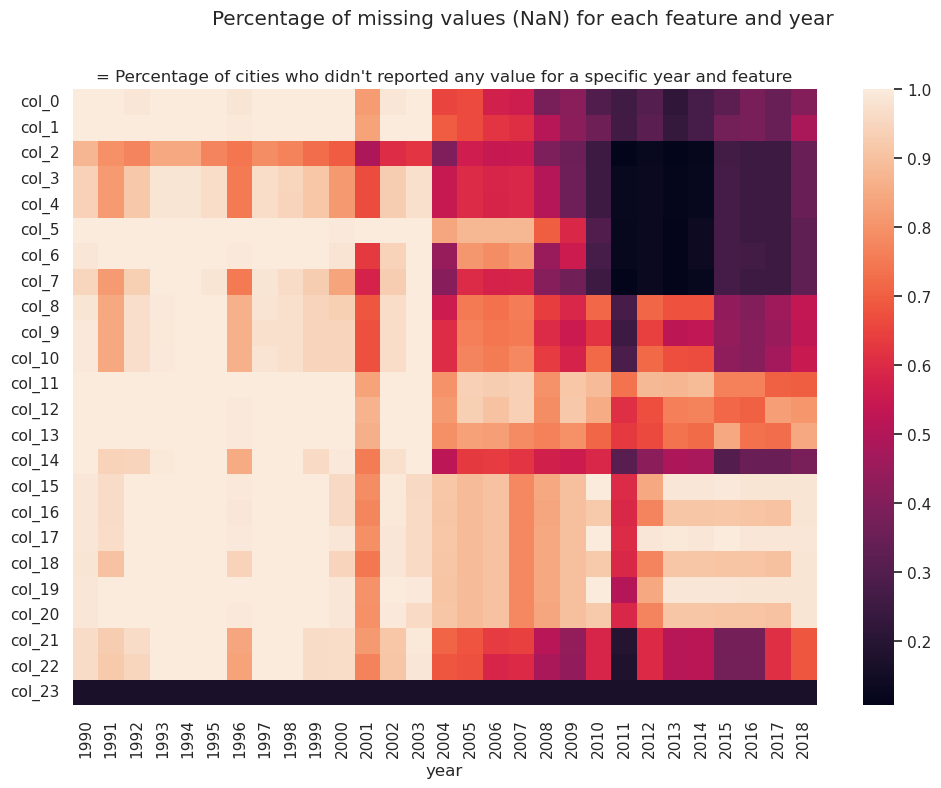

In [12]:
#DETAILED MISSING DATA ANALYSIS
#EVTL. TODO: kürzere label texte

obs = df_urban_missing.loc[2010,:].shape[0] #number of observations (=number of cities)

fig,ax = plt.figure(figsize=(12,8)),plt.axes()
df_urban_y = pd.pivot_table(df_urban_missing,index="year",aggfunc="count").loc[1990:2018]
cols = df_urban_y.columns[:-2]
sns.heatmap((1-df_urban_y[cols]/obs).T,ax=ax,yticklabels=["col_"+str(i) for i in range(len(cols))])
#display(df_cities_y/obs)
fig.suptitle("Percentage of missing values (NaN) for each feature and year")
ax.set_title("= Percentage of cities who didn't reported any value for a specific year and feature")
plt.show()

#Conclusio: Missing Data Handling might require advanced methods or extrapolation following obserevd trends (lin/poly)
# -> Miss.D.H. mit ML Tools sinnvoll? zB Gesamttrend (alle Städte) modellieren und auf einzelne Städte anwenden

In [13]:
list(enumerate(df_urban_missing.columns))

[(0,
  'Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt'),
 (1, 'Erwerbsbevölkerung, insgesamt'),
 (2, 'Erwerbslose, insgesamt'),
 (3, 'Bevölkerung am 1. Januar, insgesamt'),
 (4, 'Bevölkerung am 1. Januar, männlich'),
 (5, 'Bevölkerung am 1. Januar, weiblich'),
 (6, 'Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km'),
 (7, 'Zugelassene Privat-Pkw'),
 (8, 'Bei Straßenverkehrsunfällen getötete Personen'),
 (9, 'Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt'),
 (10, 'Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt'),
 (11, 'Bevölkerung im Alter von 65+ Jahren, insgesamt'),
 (12, 'area sqm'),
 (13, 'Erwerbslosenquote'),
 (14, 'Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %'),
 (15,
  'Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %'),
 (16, 'Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %'),
 (17, 'Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %'),
 

In [14]:
#INVESTIGATION OF MISSING DATA HANDLING STRATEGIES
# Kurvenschar - gemeinsamer Trend erkennbar?

ids = pd.IndexSlice
mmscaler = MinMaxScaler()

def plot_line_c(country,feature,df,ax):
    df_ = df[df["country"] == country].select_dtypes([np.number])
    cities = df_.index.get_level_values("kernel").unique()
    fails = []
    for ct in cities:
        ct_df = df_.loc[ids[:,ct],feature]
        x = ct_df.index.get_level_values("year").unique()
        y = ct_df.values
        ax.plot(x,y,label=ct,color="tab:grey")

def make_line_plots(feature):
    fig,ax = plt.figure(figsize=(10,6)),plt.axes()
    countries = df_urban_missing["country"].unique()
    for country in countries:
        plot_line_c(country,feature,df_urban_missing,ax)

    plt.xlim(1990,2018)
    plt.show()

feat_d = widgets.Dropdown(options = list(df_urban_missing.columns))
    
interact(make_line_plots,feature = feat_d);
#Conclusio: Extrapolation nicht sinnvoll möglich: Zeitfenster auf 2004-2018 begrenzen!
# Studenten: Interpolation für Werte zwischen 2004-2018; bzw Extrapolation bis 2018;

interactive(children=(Dropdown(description='feature', options=('Studierende an Hochschuleinrichtungen (ISCED-S…

In [15]:
#MISSING DATA REPLACEMENT


# OPTION:Alle, für welche keine einziger Datenpunkt gegeben ist, werden gedroppt
# wenn eine Stadt jetzt für ein Feature nicht einen einzigen Wert reported hat, wird sie gedroppt -> 187 Städte Rest würden bleiben
def drop_all_nans(df):
    pv = pd.pivot_table(df,index="kernel",aggfunc="mean")
    all_v_cts = list(pv.dropna(axis=0).index.unique())
    return df.loc[ids[2004:2018,all_v_cts],:]

#OPTION: Ersetzen durch europäisches Mittel in der Stadtkategorie im entsprechenden Jahr
def city_cat(n):
    lims = [5000,10000,20000,50000,100000,500000] #kategorien einwohnerzahl wikipedia
    i=0
    while i < len(lims):
        if n > lims[i]:
            i += 1
        else:
            return i
    return i

def mdh():
    # Redundante Spalten
    drop = ['Zugelassene Privat-Pkw','Bei Straßenverkehrsunfällen getötete Personen','Erwerbsbevölkerung, insgesamt', 'Erwerbslose, insgesamt']
    df_urban_missing.drop(labels = drop,axis=1,inplace=True)
    df_ = df_urban_missing.copy()

    # Alle Zwischen- und Randpunkte, für welche mindestens 2 Werte gegeben sind werden interpoliert
    df_ = df_.groupby("kernel").transform(lambda x: x.interpolate(limit_direction="both"))

    #Fehlende werte, welche aus anderen geschätzt/berechnet werden können werden berechnet
    df_["Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %"].fillna(df_["Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %"]+df_["Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %"],inplace=True)
    df_["Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %"].fillna(100 - (df_["Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %"]+df_['Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %']+df_['Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %']),inplace=True)

    # OPTION 2): Alle anderen werden durch den median aller Städte des Landes im entsprechenden Jahr ersetzt:
    #e.g. the median taxi price of all cities in austria in the year 1989 was 8.70€. the only observation for that was
    # in Vienna. missing values for the other austrian cities in 1989 are replaced with 8.70€.
    df_ = df_.groupby(["year","country"]).transform(lambda x: x.fillna(x.median()))

    #REST
    #OPTION 1)
    #Alle Städte, die jetzt noch NaNs haben werden gedroppt. für Sie (stadt) wurde weder ein einziger Datenpunkt über den 
    # gesamten Zeitraum reported noch hat eine andere stadt im selben land jemals einen Datenpunkt reported

    #cts_to_drop = df_[df_.isnull().any(axis=1)].index.get_level_values("kernel").unique()
    #df_.drop(labels = cts_to_drop,axis=0,level=1,inplace=True)
    #df_["country"] = df_.reset_index()["kernel"].apply(lambda x: x[:2]).values


    df_["cat"] = df_["Bevölkerung am 1. Januar, insgesamt"].apply(lambda x: city_cat(x))
    df_.groupby("cat").transform(lambda x: x.fillna(x.mean()))

    #ZULETZT
    #Ersetzen durch den gesamteuropäischen mittelwert im entsrechenden jahr
    df_ = df_.groupby("year").transform(lambda x: x.fillna(x.mean()))
    
    return df_.loc[ids[1990:2018,:],:]

#df_urban = mdh()
#df_urban.to_pickle("data/pickle/df_urban.pkl")

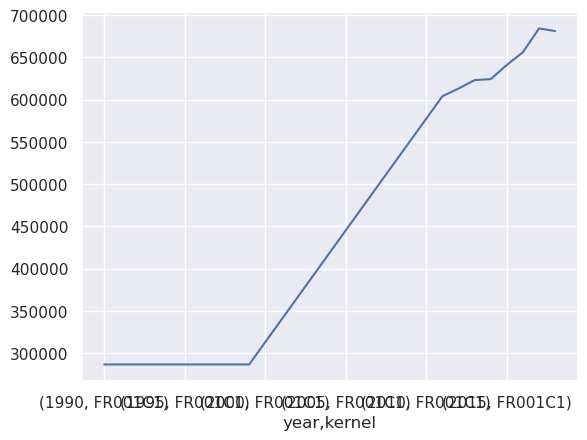

In [16]:

df_urban = pd.read_pickle("data/pickle/df_urban.pkl")

df_urban.loc[ids[:,"FR001C1"],"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt"].plot()
#"FR001C1" in df_.index.get_level_values(1)
plt.show()

In [94]:
df_urban.loc[ids[:,"PL001C1"],:]

,,"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt","Bevölkerung am 1. Januar, insgesamt","Bevölkerung am 1. Januar, männlich","Bevölkerung am 1. Januar, weiblich",Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km,"Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt","Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt","Bevölkerung im Alter von 65+ Jahren, insgesamt",area sqm,Erwerbslosenquote,...,Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %,Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %,Preis einer kombinierten Monatskarte (alle öffentlichen Verkehrsmittel) für Fahrten ins Stadtzentrum von 5 bis 10 km - EUR,Preis einer Taxifahrt aus einer Entfernung von 5 km in das Stadtzentrum (tagsüber) - EUR,Zugelassene Pkw je 1000 Einwohner,Bei Straßenverkehrsunfällen getötete Personen je 10 000 Einwohner,n_cities,cat
year,kernel,,,,,,,,,,,,,,,,,,,,,
1990,PL001C1,74184.000000,1.655272e+06,772938.000000,882334.000000,200.000000,131181.0,1.200567e+06,197344.000000,2.382448e+08,11.666868,...,2.229079,6.100227,12.124251,62.523393,17.970,3.270000,321.86,0.73,69,6
1991,PL001C1,74184.000000,1.655272e+06,772938.000000,882334.000000,200.000000,131181.0,1.200567e+06,197344.000000,2.382448e+08,11.675131,...,2.228067,6.102147,12.122247,62.524530,17.970,3.270000,321.86,0.73,69,6
1992,PL001C1,90489.600000,1.644515e+06,769192.000000,880726.600000,200.000000,131181.0,1.200567e+06,207347.800000,2.382448e+08,11.723176,...,2.239341,6.103981,12.106741,62.525954,17.970,3.270000,336.38,0.73,69,6
1993,PL001C1,106795.200000,1.641381e+06,765446.000000,879119.200000,200.000000,131181.0,1.200567e+06,217351.600000,2.382448e+08,11.739547,...,2.250467,6.105996,12.091192,62.526928,17.970,3.270000,350.90,0.73,69,6
1994,PL001C1,123100.800000,1.638246e+06,761700.000000,877511.800000,200.000000,131181.0,1.200567e+06,227355.400000,2.382448e+08,11.752694,...,2.261592,6.108010,12.074886,62.527902,17.970,3.270000,365.42,0.73,69,6
1995,PL001C1,139406.400000,1.635112e+06,757954.000000,875904.400000,200.000000,131181.0,1.200567e+06,237359.200000,2.382448e+08,11.765357,...,2.272534,6.109704,12.058127,62.528876,17.970,3.270000,379.94,0.73,69,6
1996,PL001C1,155712.000000,1.628505e+06,754208.000000,874297.000000,200.000000,131181.0,1.200567e+06,247363.000000,2.382448e+08,11.780720,...,2.283477,6.111399,12.041368,62.529850,17.970,3.270000,394.46,0.73,69,6
1997,PL001C1,191841.800000,1.624843e+06,758843.833333,879777.166667,200.000000,131181.0,1.200567e+06,252663.166667,2.382448e+08,11.647051,...,2.293950,6.111946,12.021800,62.531200,17.970,3.270000,397.27,0.73,69,6
1998,PL001C1,227971.600000,1.618468e+06,763479.666667,885257.333333,200.000000,131181.0,1.200567e+06,257963.333333,2.382448e+08,11.528134,...,2.304178,6.114144,12.003466,62.529480,17.970,3.270000,400.08,0.73,69,6


In [17]:
# Missind Data Handling Plausibilitätscheck

df_urban_missing = pd.read_pickle("data/pickle/df_urban_missing.pkl")
df_urban_missing = df_urban_missing.loc[ids[1990:2018,:],:]

df_urban_complete = pd.read_pickle("data/pickle/df_urban.pkl")

ct_drop = widgets.Dropdown(options = sorted(df_urban_missing.index.get_level_values("kernel").unique()))
feat_dr = widgets.Dropdown(options = list(df_urban_missing.columns))
#ci_check = widgets.Checkbox(value = False,description = "95% CI")

display(widgets.HBox([ct_drop,feat_dr]))
out13 = interactive_output(plot_compare,{"country":ct_drop,"feature":feat_dr,"df_missing":fixed(df_urban_missing),"df_complete":fixed(df_urban_complete)})

display(out13)

Output()

# Correlation Analysis

## National Level

In [18]:

df_national_complete = pd.read_pickle("data/pickle/df_national.pkl")

df_corr_nat = df_national_complete.copy()
df_corr_nat["Busse pro Tausend Einwohner Anzahl"] = df_national_complete["Busse Insgesamt Anzahl"] * 1000 / df_national_complete["Total population"]

df_corr_nat["Population aged 0-14 (%)"] = df_national_complete["Population aged 0-14"] / df_national_complete["Total population"]
df_corr_nat["Population aged 15-64 (%)"] = df_national_complete["Population aged 15-64"] / df_national_complete["Total population"]
df_corr_nat["Population aged 65+ (%)"] = df_national_complete["Population aged 65+"] / df_national_complete["Total population"]

df_corr_nat.drop(columns = ["Busse Insgesamt Anzahl",
                            "Population aged 0-14",
                            "Population aged 15-64",
                            "Population aged 65+"], inplace=True)

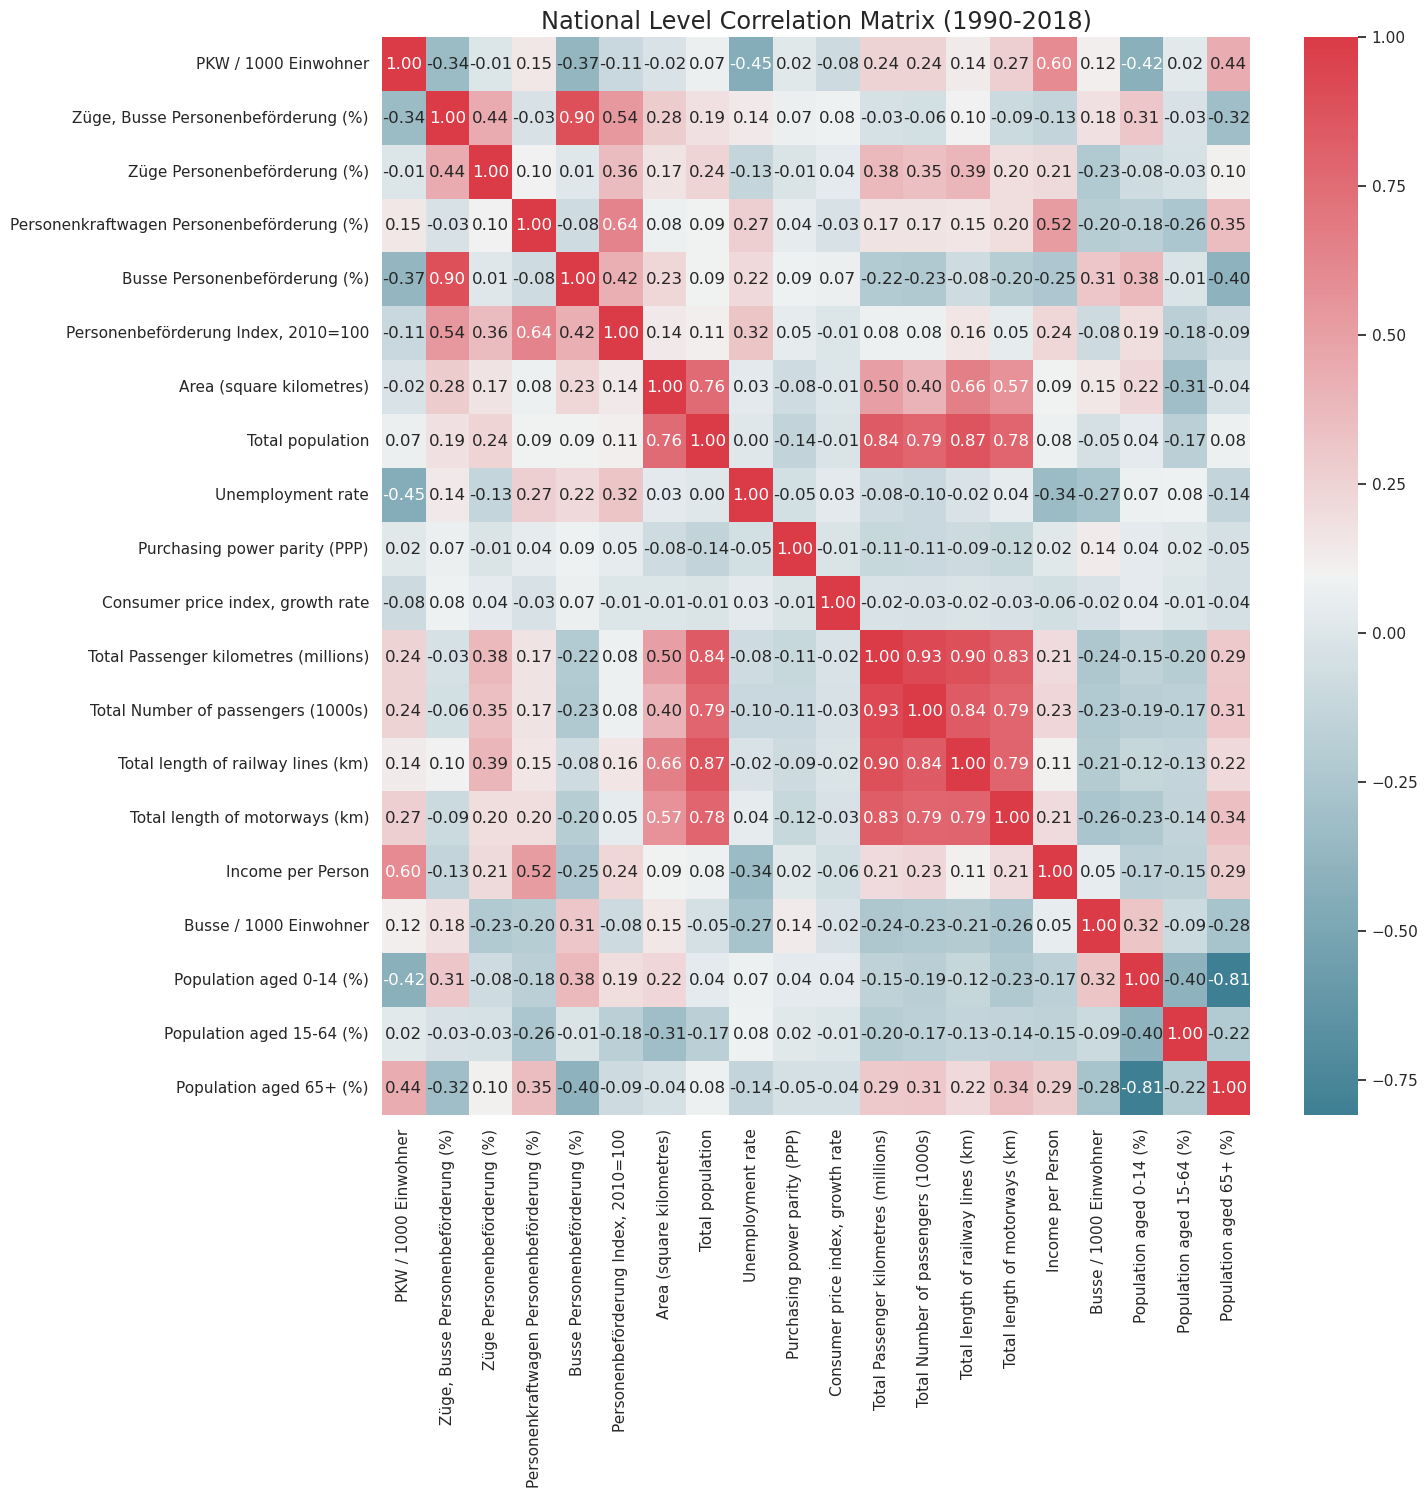

In [19]:
def plot_corr_matrix(correlations, title, col_labels="auto"):
    # Generate colormap
    colormap = sns.diverging_palette(220, 10, as_cmap=True) # Generate Color Map

    plt.figure(figsize = (14,14))
    ax = sns.heatmap(correlations, cmap=colormap, annot=True, fmt=".2f", xticklabels=col_labels, yticklabels=col_labels)

    ax.set_title(title, fontsize="x-large")
    plt.show()
    
# Compute the correlation matrix
col_lables = ['PKW / 1000 Einwohner',
       'Züge, Busse Personenbeförderung (%)',
       'Züge Personenbeförderung (%)',
       'Personenkraftwagen Personenbeförderung (%)',
       'Busse Personenbeförderung (%)',
       'Personenbeförderung Index, 2010=100', 'Area (square kilometres)',
       'Total population', 'Unemployment rate',
       'Purchasing power parity (PPP)',
       'Consumer price index, growth rate',
       'Total Passenger kilometres (millions)',
       'Total Number of passengers (1000s)',
       'Total length of railway lines (km)',
       'Total length of motorways (km)',
       'Income per Person',
       'Busse / 1000 Einwohner', 'Population aged 0-14 (%)',
       'Population aged 15-64 (%)', 'Population aged 65+ (%)']

plot_corr_matrix(df_corr_nat.corr(),"National Level Correlation Matrix (1990-2018)", col_lables)

In [20]:
#COMPARE TWO FEATURES OVER TIME
def filtered_mean(list):
    count = 0
    sum = 0
    for li in list:
        if not(np.isnan(li) or np.isinf(li) or li == 0):
            sum += li
            count += 1
    return sum/count if count > 0 else np.nan

def plot_2_attr(**kwargs):
    attr1 = kwargs["attr1"]
    attr2 = kwargs["attr2"]
    country = kwargs["country"]
    d_range = kwargs["d_range"]
    data = kwargs["data"]
    
    fig = plt.figure(figsize = (12,6))
    ax1 = plt.axes()
    ax2 = ax1.twinx()
    
    ids = pd.IndexSlice
    x = data.index.get_level_values("year").unique()
    
    if country == "Mean":
        y1 = []
        y2 = []
        for year in x:
            attr1_value = data.loc[year][attr1]
            attr2_value = data.loc[year][attr2]
            y1.append(filtered_mean(attr1_value))
            y2.append(filtered_mean(attr2_value))
    else:
        y1 = data.loc[ids[:,country],attr1].values
        y2 = data.loc[ids[:,country],attr2].values
        
    ax1.plot(x,y1, color="tab:blue", label=attr1)
    ax2.plot(x,y2, color="tab:red", label=attr2)
    
    ax1.set_xlabel("Year")
    ax1.set_ylabel(attr1)
    ax2.set_ylabel(attr2)

    ax1.set_title(country + ": " + attr1 + " & " + attr2)
    plt.xlim(d_range)
    fig.legend(loc="upper right")
    plt.show()
    

countries = df_corr_nat.index.get_level_values("country").unique()
years = df_corr_nat.index.get_level_values("year").unique()
attributes = df_corr_nat.columns

rb_options = list(countries)
rb_options.insert(0, "Mean")

rb = widgets.Dropdown(
    options = rb_options,
    description = 'Country:',
    disabled = False
)

attr_ui1 = widgets.Dropdown(options = attributes, value = "Personenkraftwagen Personenbeförderung Prozent")
attr_ui2 = widgets.Dropdown(options = attributes, value = "income_per_person_gdppercapita_ppp_inflation_adjusted")
range_ui = widgets.IntRangeSlider(value = (1990,2018),min =min(years) ,max = max(years),continuous_update=False)

kwargs = {}
kwargs["attr1"] = attr_ui1
kwargs["attr2"] = attr_ui2
kwargs["country"] = rb
kwargs["d_range"] = range_ui
kwargs["data"] = fixed(df_corr_nat)

b = widgets.HBox([attr_ui1,attr_ui2,range_ui])

out13 = interactive_output(plot_2_attr,kwargs)
display(rb,b,out13)

Dropdown(description='Country:', options=('Mean', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', …

Output()

In [22]:
#CORRELATION OF FEATURES OVER TIIME
def plot_corr(**kwargs):
    attr1 = kwargs["attr1"]
    attr2 = kwargs["attr2"]
    d_range = kwargs["d_range"]
    data = kwargs["data"]

    fig,ax = plt.figure(figsize=(10,6)),plt.axes()
    years = data.index.get_level_values("year").unique()
    values = []
    for year in years:
        values.append(data.loc[year][attr1].corr(data.loc[year][attr2]))
    ax.plot(years,values,label="corr")
    mean,std = np.mean(values),np.std(values)
    ax.hlines(mean,min(years),max(years),color="black",label="mean",linewidth = .5)
    ax.fill_between(years,[mean + 1.96*std for _ in years],[mean -1.96*std for _  in years],color="tab:grey",alpha=0.2,label="95% CI")
    ax.set_title("Correlation over time between: " + attr1 + " & " + attr2)
    plt.xlim(d_range)
    plt.ylim(-1.05,1.05)
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Correlation Coefficient")
    ax.legend()
    plt.show()

years = df_corr_nat.index.get_level_values("year").unique()
attributes = df_corr_nat.columns

attr_ui1 = widgets.Dropdown(options = attributes, value = "Personenkraftwagen Personenbeförderung Prozent")
attr_ui2 = widgets.Dropdown(options = attributes, value = "income_per_person_gdppercapita_ppp_inflation_adjusted")
range_ui = widgets.IntRangeSlider(value = (1990,2018),min =min(years) ,max = max(years),continuous_update=False)

kwargs = {}
kwargs["attr1"] = attr_ui1
kwargs["attr2"] = attr_ui2
kwargs["d_range"] = range_ui
kwargs["data"] = fixed(df_corr_nat)

b = widgets.HBox([attr_ui1,attr_ui2,range_ui])

out14 = interactive_output(plot_corr,kwargs)
display(b,out14)

Output()

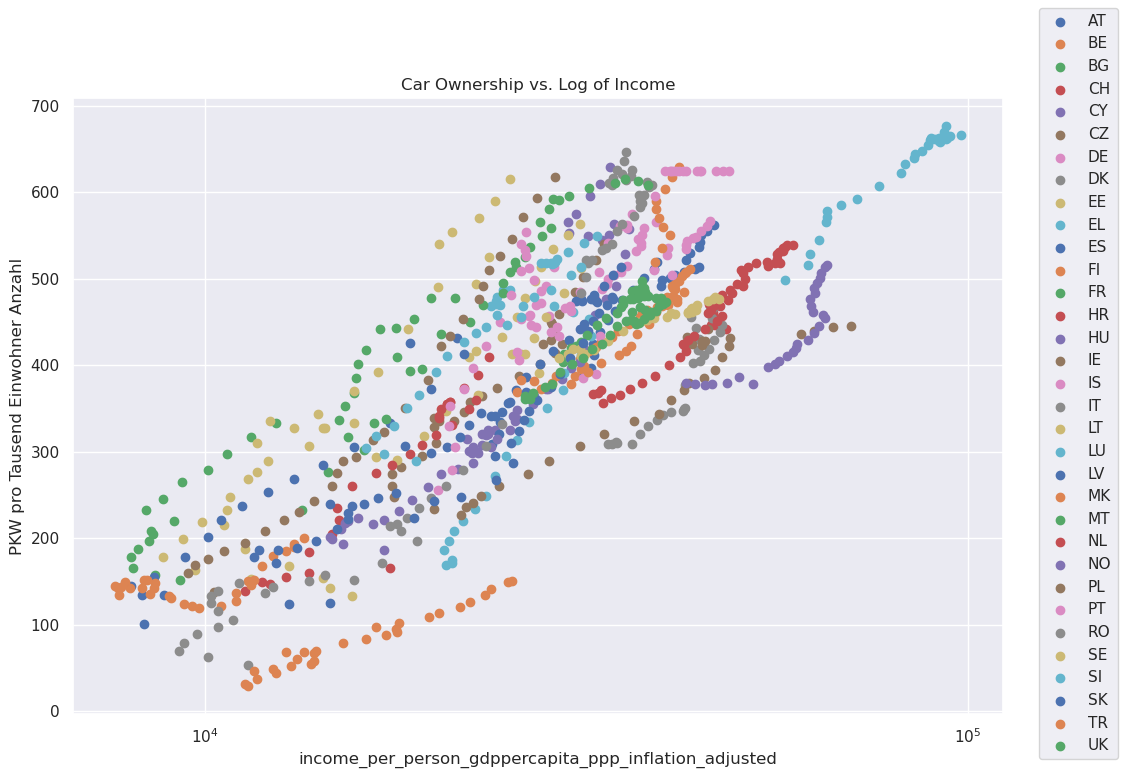

In [24]:
# Scatterplot Car Ownership vs. Log of Income, colored by country
attr1 = "income_per_person_gdppercapita_ppp_inflation_adjusted"
attr2 = "PKW pro Tausend Einwohner Anzahl"
df_plot = df_corr_nat[(df_corr_nat[attr1] > 0) & df_corr_nat[attr2] > 0]

fig,ax = plt.figure(figsize=(12,8)),plt.axes()
countries = df_plot.index.get_level_values("country").unique()
for country in countries:
    plt.scatter(df_plot[df_plot.index.get_level_values("country") == country][attr1],df_plot[df_plot.index.get_level_values("country") == country][attr2],label=country)
ax.set_xlabel(attr1)
ax.set_ylabel(attr2)
ax.set_xscale("log")
ax.set_title("Car Ownership vs. Log of Income")
fig.legend()
plt.show()

## Urban Level

In [357]:

df_urban_complete = pd.read_pickle("data/pickle/df_urban.pkl")
df_corr_urb = df_urban_complete.copy()

df_corr_urb["Population Male (%)"] = df_corr_urb["Bevölkerung am 1. Januar, männlich"] / df_corr_urb["Bevölkerung am 1. Januar, insgesamt"]
df_corr_urb["Population Female (%)"] = df_corr_urb["Bevölkerung am 1. Januar, weiblich"] / df_corr_urb["Bevölkerung am 1. Januar, insgesamt"]


df_corr_urb["Population aged 0-14 (%)"] = df_corr_urb["Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt"] / df_corr_urb["Bevölkerung am 1. Januar, insgesamt"]
df_corr_urb["Population aged 15-64 (%)"] = df_corr_urb["Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt"] / df_corr_urb["Bevölkerung am 1. Januar, insgesamt"]
df_corr_urb["Population aged 65+ (%)"] = df_corr_urb["Bevölkerung im Alter von 65+ Jahren, insgesamt"] / df_corr_urb["Bevölkerung am 1. Januar, insgesamt"]

df_corr_urb.drop(columns = ['n_cities',
                            'cat',
                            'Bevölkerung am 1. Januar, männlich',
                            'Bevölkerung am 1. Januar, weiblich',
                            'Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt',
                            'Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt',
                            'Bevölkerung im Alter von 65+ Jahren, insgesamt'],
                 inplace=True)

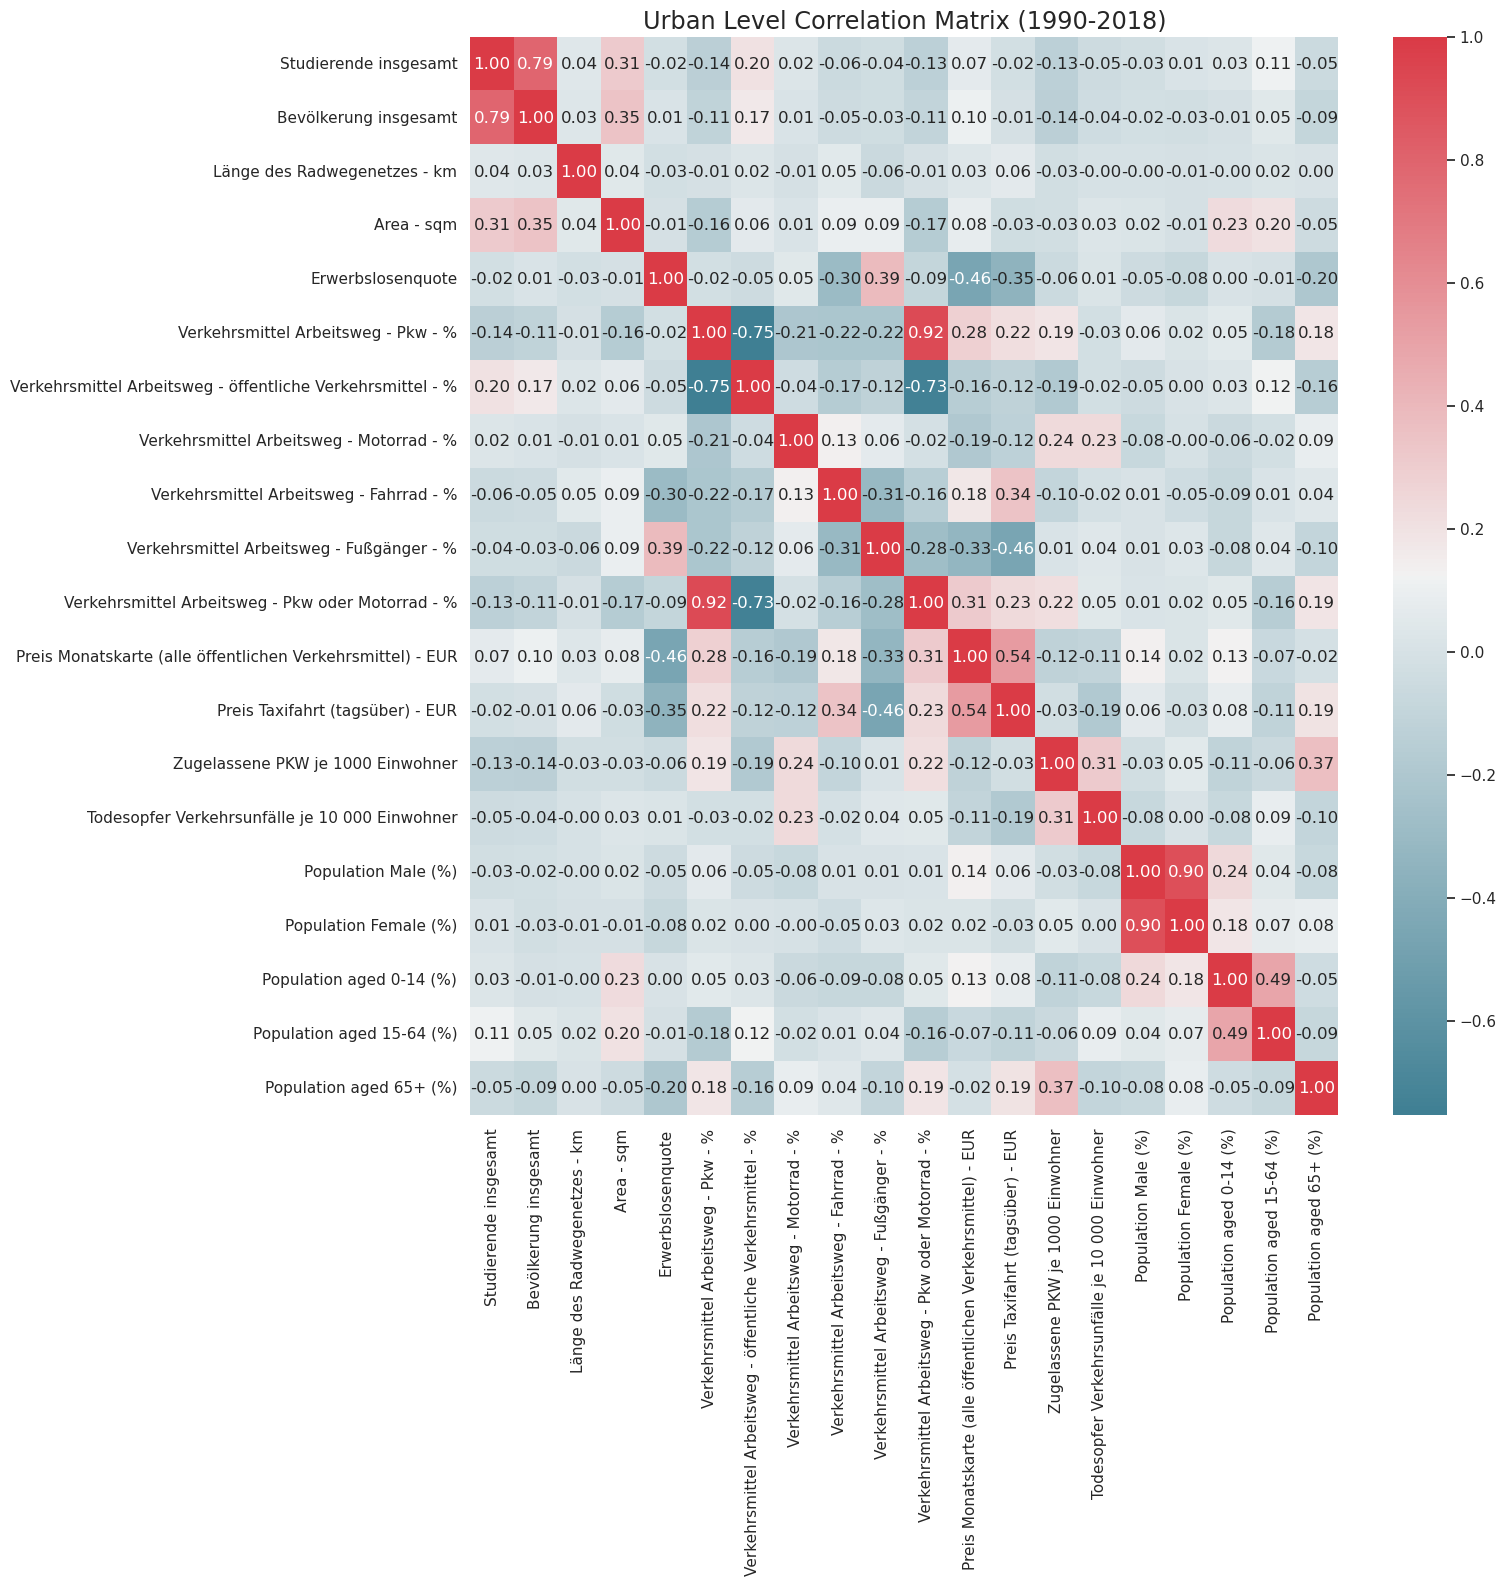

In [358]:
col_lables = ['Studierende insgesamt',
       'Bevölkerung insgesamt',
       'Länge des Radwegenetzes - km',
       'Area - sqm', 'Erwerbslosenquote',
       'Verkehrsmittel Arbeitsweg - Pkw - %',
       'Verkehrsmittel Arbeitsweg - öffentliche Verkehrsmittel - %',
       'Verkehrsmittel Arbeitsweg - Motorrad - %',
       'Verkehrsmittel Arbeitsweg - Fahrrad - %',
       'Verkehrsmittel Arbeitsweg - Fußgänger - %',
       'Verkehrsmittel Arbeitsweg - Pkw oder Motorrad - %',
       'Preis Monatskarte (alle öffentlichen Verkehrsmittel) - EUR',
       'Preis Taxifahrt (tagsüber) - EUR',
       'Zugelassene PKW je 1000 Einwohner',
       'Todesopfer Verkehrsunfälle je 10 000 Einwohner',
       'Population Male (%)', 'Population Female (%)',
       'Population aged 0-14 (%)', 'Population aged 15-64 (%)',
       'Population aged 65+ (%)']

plot_corr_matrix(df_corr_urb.corr(),"Urban Level Correlation Matrix (1990-2018)", col_lables)

# Clustering

## Country Clusters

silhouette score: 0.6072697940959276


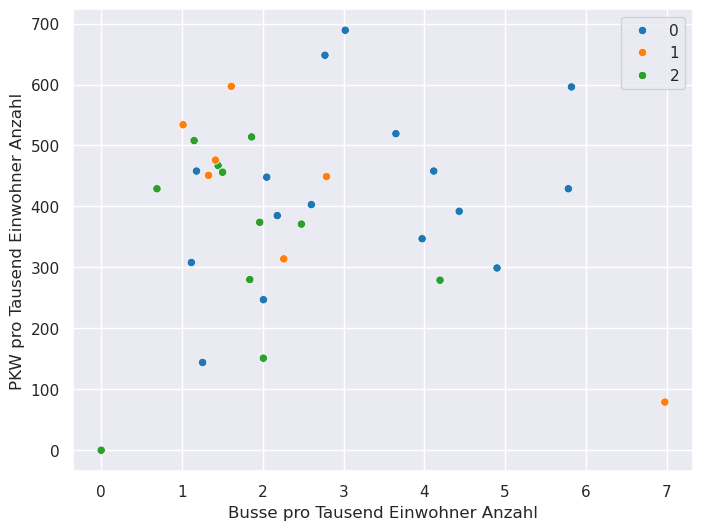

In [27]:
def color_gen(colors = sns.color_palette("tab10")):
    i = 0
    while True:
        yield colors[i%len(colors)]
        i += 1


df_national_complete = pd.read_pickle("data/pickle/df_national.pkl")

#Features vergleichbar machen -> abs. werte auf relative umrechnen  
df_national_complete.drop(labels=["XK"],axis="index",level=1,inplace=True) #has inf in at least one col
df_national_complete["Busse pro Tausend Einwohner Anzahl"] = df_national_complete["Busse Insgesamt Anzahl"] * 1000 / df_national_complete["Total population"]
df_national_complete["Passenger km pro Tausend Einwohner (millions)"] = df_national_complete[ 'Passengers Total Passenger kilometres (millions)']*1000 / df_national_complete["Total population"]
df_national_complete['Passengers Total Number pro Tausend Einwohner'] = df_national_complete['Passengers Total Number of passengers (1000s)']/df_national_complete["Total population"]
df_national_complete['Length of railway lines (km) pro Tausend Einwohner'] = df_national_complete['Total length of railway lines (km)']*1000 / df_national_complete["Total population"]
df_national_complete['Length of motorways (km) pro Tausend Einwohner'] = df_national_complete['Total length of motorways (km)']* 1000 / df_national_complete["Total population"]

gen = color_gen()

cluster_features = ['Busse pro Tausend Einwohner Anzahl',
 'PKW pro Tausend Einwohner Anzahl',
 'Züge Personenbeförderung Prozent',
 'Personenkraftwagen Personenbeförderung Prozent',
 'Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent',
 'Total population',
 'Unemployment rate',
 'Purchasing power parity (PPP), NCU per US$',
 'Consumer price index, growth rate',
 "Passenger km pro Tausend Einwohner (millions)",
 'Passengers Total Number pro Tausend Einwohner',
 'Length of railway lines (km) pro Tausend Einwohner',
 'Length of motorways (km) pro Tausend Einwohner',
 'income_per_person_gdppercapita_ppp_inflation_adjusted']

df_cluster = df_national_complete[cluster_features].groupby('country').median()

km = KMeans(n_clusters=3)
y_pred = km.fit_predict(df_cluster)

country_cls = {ctr:lbl for ctr,lbl in zip(list(df_cluster.index), y_pred)}

print("silhouette score:",silhouette_score(df_cluster, y_pred))

plt.figure(figsize=(8,6))

sns.scatterplot(x=cluster_features[0], y=cluster_features[1], hue=km.labels_, data=df_cluster,palette = [next(gen) for i in range(len(set(y_pred)))])
plt.show()

#scores an even higher silh.score for k=2 clusters

In [30]:
df_cluster["cat"] = y_pred

def plot_radar_chart(df,kmeans,scaler=None):
    fig,ax = plt.figure(figsize=(7,7)),plt.axes(polar=True)
    
    df_mean = df.groupby("cat").mean()
    #df_mean = df.groupby("cat").median()
    
    if scaler == "std":
        df_g = pd.DataFrame(data=StandardScaler().fit_transform(df_mean),columns = df_mean.columns)
    elif scaler == "minmax":
        df_g = pd.DataFrame(data=MinMaxScaler().fit_transform(df_mean),columns = df_mean.columns)
    else:
        df_g = pd.DataFrame(data=kmeans.cluster_centers_,columns=df_mean.columns)
        scaler = "Centers"

    for cls in df_g.index:
        means = df_g.loc[cls].values
        angles=np.linspace(0, 2*np.pi, len(df_g.columns), endpoint=False)

        stats = np.concatenate((means,[means[0]]))
        angles = np.concatenate((angles,[angles[0]]))
        ax.plot(angles, stats, 'o-', linewidth=2,label="class {}".format(cls))
        ax.fill(angles, stats, alpha=0.2)

    labels = list(df_g.columns)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    fig.suptitle("{}  per feature and class".format(scaler+" scaled means"))
    fig.legend()
    plt.show()

rd=widgets.RadioButtons(options = ["std","minmax"])

interact(plot_radar_chart,df=fixed(df_cluster),kmeans=fixed(km),scaler=rd);

interactive(children=(RadioButtons(description='scaler', options=('std', 'minmax'), value='std'), Output()), _…

In [84]:
#CLUSTER STATS
df_cluster.groupby("cat").agg(["mean","std"])

Busse pro Tausend Einwohner Anzahl            \
                                  mean       std   
cat                                                
0                             2.465540  1.563151   
1                             2.761233  2.447833   
2                             1.794361  0.658724   

    PKW pro Tausend Einwohner Anzahl              \
                                mean         std   
cat                                                
0                         381.252874  164.426846   
1                         427.000000  202.693118   
2                         382.500000   96.873629   

    Züge Personenbeförderung Prozent            \
                                mean       std   
cat                                              
0                           5.148768  4.119428   
1                           6.220000  2.359449   
2                           6.800000  1.979899   

    Personenkraftwagen Personenbeförderung Prozent             \
                                              mean        std   
cat                                                             
0                                        77.931034  16.357526   
1                                        78.560000  15.377191   
2                                        76.750000   6.576093   

    Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent  \
                                                                   mean   
cat                                                                       
0                                            13.544828                    
1                                            15.160000                    
2                                            15.900000                    

                ... Passenger km pro Tausend Einwohner (millions)            \
           std  ...                                          mean       std   
cat             ...                                                           
0     6.694805  ...                                      0.492057  0.459350   
1    17.361682  ...                                      0.728936  0.408061   
2     3.818377  ...                                      0.487233  0.047650   

    Passengers Total Number pro Tausend Einwohner            \
                                             mean       std   
cat                                                           
0                                        0.011266  0.011585   
1                                        0.012999  0.008378   
2                                        0.008964  0.001431   

    Length of railway lines (km) pro Tausend Einwohner            \
                                                  mean       std   
cat                                                                
0                                             0.536082  0.313348   
1                                             0.329561  0.151166   
2                                             0.419531  0.158655   

    Length of motorways (km) pro Tausend Einwohner            \
                                              mean       std   
cat                                                            
0                                         0.107431  0.088710   
1                                         0.102721  0.059205   
2                                         0.132421  0.166826   

    income_per_person_gdppercapita_ppp_inflation_adjusted                
                                                     mean           std  
cat                                                                      
0                                         29527.241379     18079.309977  
1                                         32020.000000      9435.147058  
2                                         23900.000000     10323.759005  

[3 rows x 28 columns]

In [36]:
df_cluster.loc[df_cluster.loc[:,"cat"]==2]

,Busse pro Tausend Einwohner Anzahl,PKW pro Tausend Einwohner Anzahl,Züge Personenbeförderung Prozent,Personenkraftwagen Personenbeförderung Prozent,"Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent",Total population,Unemployment rate,"Purchasing power parity (PPP), NCU per US$","Consumer price index, growth rate",Passenger km pro Tausend Einwohner (millions),Passengers Total Number pro Tausend Einwohner,Length of railway lines (km) pro Tausend Einwohner,Length of motorways (km) pro Tausend Einwohner,income_per_person_gdppercapita_ppp_inflation_adjusted,cat
country,,,,,,,,,,,,,,,
AT,1.150501,508.0,11.500000,79.3,9.3,8171966.0,4.700000,0.8819,2.1,1.181619,0.026591,0.705513,0.202716,40700.0,2
BE,1.447796,467.0,6.600000,81.8,11.3,10421136.0,8.200000,0.8799,2.1,0.832539,0.017121,0.335790,0.164854,39200.0,2
BG,4.194536,279.0,5.100000,69.8,24.0,7716860.0,12.357692,0.5808,5.9,0.321125,0.004488,0.549081,0.042893,11500.0,2
CH,1.861956,514.0,15.500000,79.6,5.2,7389625.0,3.900000,1.6933,0.8,2.018235,0.047734,0.638766,0.177230,51500.0,2
CZ,1.962040,374.0,8.400000,73.3,18.2,10343551.4,6.100000,13.2977,2.8,0.714425,0.017745,0.913464,0.053545,24200.0,2
EL,2.478471,371.0,1.600000,77.5,20.9,10820883.0,10.300000,0.6479,3.4,0.148990,0.001198,0.229765,0.065724,24400.0,2
HU,1.839369,280.0,12.100000,64.5,23.2,10107146.0,6.900000,124.2718,6.0,0.825204,0.015276,0.751234,0.056297,21500.0,2
NL,0.690353,429.0,9.314286,86.0,3.9,16281779.0,5.700000,0.8971,2.1,0.969323,0.020799,0.179284,0.157615,43000.0,2
PT,1.506541,457.0,4.400000,85.1,10.9,10358076.0,7.900000,0.6231,2.7,0.392875,0.015008,0.269010,0.204600,26000.0,2


In [85]:
#CLUSTER CENTERS
pd.DataFrame(km.cluster_centers_,columns = df_cluster.columns[:-1])

,Busse pro Tausend Einwohner Anzahl,PKW pro Tausend Einwohner Anzahl,Züge Personenbeförderung Prozent,Personenkraftwagen Personenbeförderung Prozent,"Busse, Reisebusse und Oberleitungsbusse Personenbeförderung Prozent",Total population,Unemployment rate,"Purchasing power parity (PPP), NCU per US$","Consumer price index, growth rate",Passenger km pro Tausend Einwohner (millions),Passengers Total Number pro Tausend Einwohner,Length of railway lines (km) pro Tausend Einwohner,Length of motorways (km) pro Tausend Einwohner,income_per_person_gdppercapita_ppp_inflation_adjusted
0,2.465540,381.252874,5.148768,77.931034,13.544828,5.933589e+06,9.141141,11.053534,3.318966,0.492057,0.011266,0.536082,0.107431,29527.241379
1,2.761233,427.000000,6.220000,78.560000,15.160000,6.594137e+07,8.360000,0.810060,4.820000,0.728936,0.012999,0.329561,0.102721,32020.000000
2,1.794361,382.500000,6.800000,76.750000,15.900000,4.054367e+07,14.457692,1.241300,3.400000,0.487233,0.008964,0.419531,0.132421,23900.000000


In [38]:
def filter_geo(cat,val,geojson):
    """
    Filter GeoJSON Data on given category and value
    params:
    - cat: Category: str; one of GeoJSON "properties" key
    - val: value to filter on; can be list
    - geojson: GeoJSON data to be filtered
    returns: GeoJSON object (dict)
    """
    res = {}
    res["type"] = geojson["type"]
    res["features"] = []
    res["crs"] = geojson["crs"]
    if not type(val) == list:
        val = [val]
    for v in val:
        for entity in geojson["features"]:
            if entity["properties"][cat] == v:
                res["features"].append(entity)
    return res


with open("data/geo/NUTS_RG_10M_2021_4326.geo.json","r",encoding="utf-8") as f:
    geo_data = json.load(f)

def country_cls_styler(*args):
    ct_id = args[0]["properties"]["FID"]
    ct_cat = country_cls[ct_id]
    return {"color":sns.color_palette().as_hex()[ct_cat]}

m9 = Map(center=(49.15,12.35), zoom = 4, basemap=basemaps.CartoDB.Positron)
geo_data = filter_geo("FID",list(country_cls.keys()),geo_data)

geojson = GeoJSON(data = geo_data, style_callback=country_cls_styler)
m9.add_layer(geojson)
l = LegendControl({"class {}".format(i):sns.color_palette().as_hex()[i] for i in set(country_cls.values())},position = "topright")
m9.add_control(l)
m9

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

## City Clusters

In [39]:
#Calculating model scores

df_urban = pd.read_pickle("data/pickle/df_urban.pkl")
ids = pd.IndexSlice

cl_features = ["Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt",
        "Bevölkerung am 1. Januar, insgesamt",
        "Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt",
        'Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt',
        'Bevölkerung im Alter von 65+ Jahren, insgesamt',
        'Erwerbslosenquote',
        'Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %',
        'Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %',
        'Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %',
        'Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %',
        'Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %',
        "Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %",
        "Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %",
        "Zugelassene Pkw je 1000 Einwohner"]    

def make_ts(feature,df):
    """
    Returns feature, labels and X for use with tslearn.cluster.TimeSeriesKMeans
    """
    ts = []
    labels = df.index.get_level_values(1).unique()
    for label in labels:
        ts.append(df.loc[ids[:,label],feature].to_numpy()[:,np.newaxis])
    return feature, labels, np.array(ts)

prbar = widgets.IntProgress(value=0,min=0,max=3*len(cl_features))
display(prbar)

def calc_silhouette_scores(cl_features):
    '''
    Dont run this. Results have been calculated already.
    '''
    scores = {}
    for feature in cl_features:
        scores[feature] = {}
        for k in [2,3,4]:
            feature,labels,X = make_ts(feature,df_urban)
            try:
                X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)
                model = TimeSeriesKMeans(n_clusters=k)
                y_pred = model.fit_predict(X_scaled)
                score = ts_silhouette_score(X_scaled,y_pred,n_jobs = -1)
                print(feature,k,score)
                scores[feature][k] = score
            except:
                print("Error bei {} und k={}".format(feature,k))
            prbar.value += 1
    return scores

#model_scores = calc_silhouette_scores(cl_features)
#with open("data/model/ts_model_score.json","w") as f:
#    json.dump(model_scores,f)

IntProgress(value=0, max=42)

In [40]:
def xkcd_color():
    colors = ["xkcd:magenta","xkcd:aqua","xkcd:neon green","xkcd:orange"]
    i = 0
    while True:
        yield colors[i%len(colors)]
        i += 1

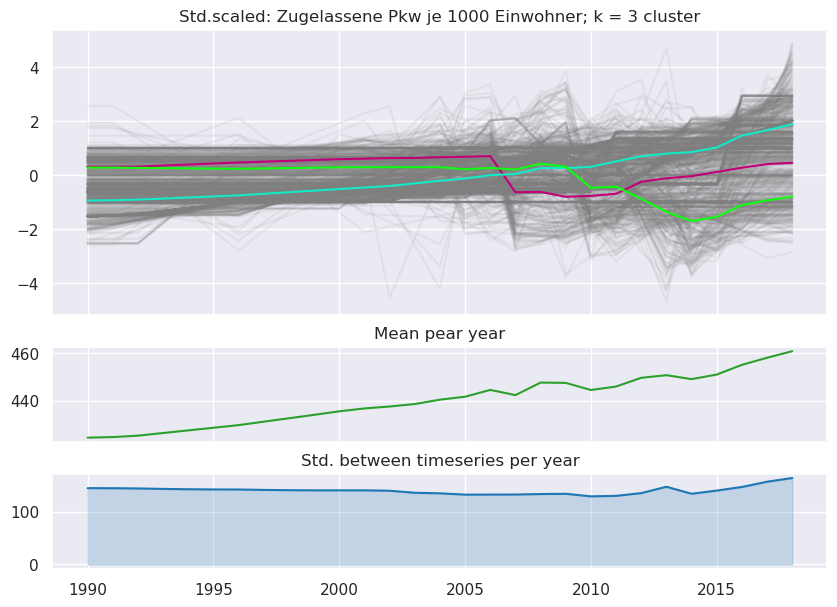

In [43]:

#Visualization: Example of TimeSeries clustering with k=3 means for one selected features
fig,axs = plt.subplots(figsize=(10,7),nrows=3,sharex=True,gridspec_kw={"height_ratios":[3,1,1]})

feature,labels,X = make_ts("Zugelassene Pkw je 1000 Einwohner",df_urban)

var = df_urban.loc[:,feature].groupby("year").std()
mn = df_urban.loc[:,feature].groupby("year").mean()

X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)
ts_model = TimeSeriesKMeans(n_clusters=3,metric="euclidean")
y_pred = ts_model.fit_predict(X_scaled)

for ts in X_scaled:
    axs[0].plot(var.index,ts.flatten(),color="tab:grey",alpha=.1)
for ts_pred,color in zip(ts_model.cluster_centers_,xkcd_color()):
    axs[0].plot(var.index,ts_pred.flatten(),color=color)
    
axs[0].set_title("Std.scaled: {}; k = {} cluster".format(feature,ts_model.n_clusters)) 
axs[1].plot(mn.index,mn.values,color="tab:green")
axs[1].set_title("Mean pear year")
axs[2].plot(var.index,var.values,color="tab:blue")
axs[2].fill_between(var.index,var.values,color='tab:blue',alpha=0.2)
axs[2].set_title("Std. between timeseries per year")
plt.show()

result = {lbl:cls for lbl,cls in zip(labels,y_pred)}

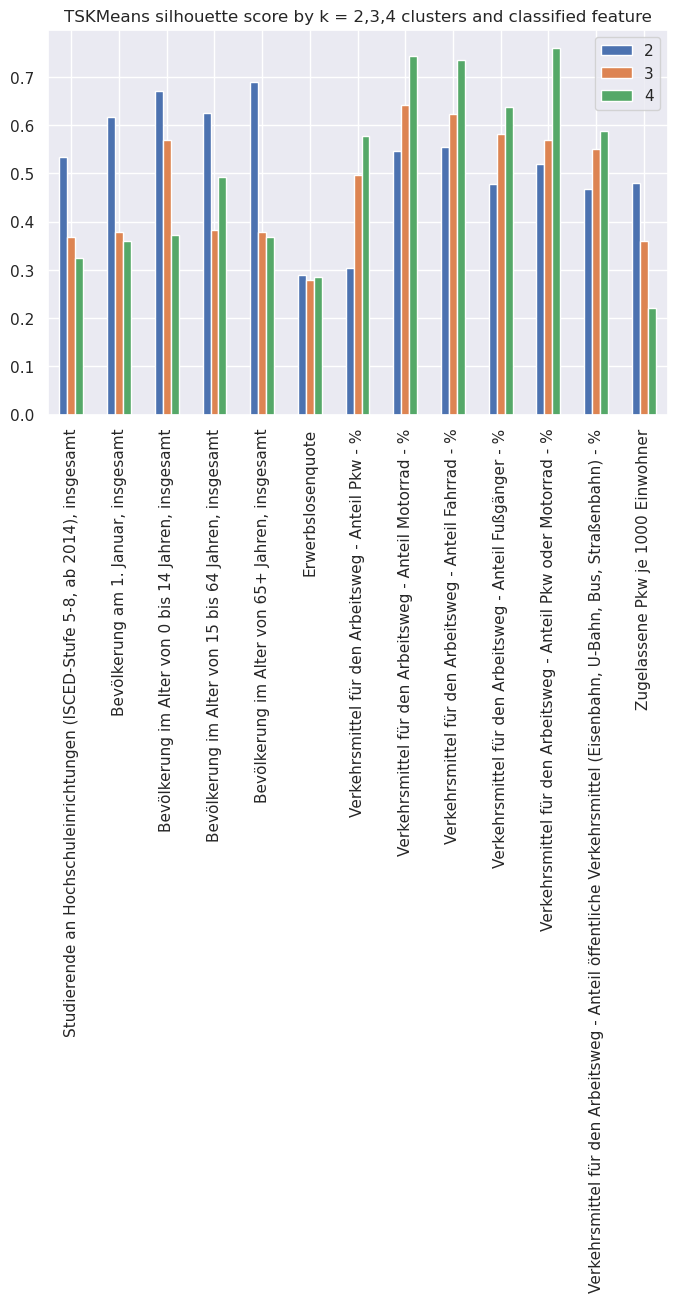

In [44]:
#TODO: Plot model scores (calculated)
with open("data/model/ts_model_score.json","r") as f:
    model_scores = json.load(f)
fig,ax =  plt.figure(figsize=(8,5)),plt.axes()
df_scores = pd.DataFrame.from_dict(model_scores).T.plot.bar(ax=ax)
ax.set_title("TSKMeans silhouette score by k = 2,3,4 clusters and classified feature")
plt.show()

#Conclusio: Socioeconomic features seem to reach highest silhouette scores for k=2 cluster; transportation related 
# features for k=4;

In [45]:
# Saving best models for quick access when plotting
def best_model_city():
    """Don't run. Already pickled."""
    best_model_city = {}
    results = {}
    for feature in model_scores.keys():
        k = int(max(model_scores[feature],key=model_scores[feature].get))
        print(feature,k)
        feat,labels,X = make_ts(feature,df_urban)
        X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)
        ts_model = TimeSeriesKMeans(n_clusters=k,metric="euclidean")
        ts_model.fit(X_scaled)
        y_pred = ts_model.fit_predict(X_scaled)
        best_model_city[feature] = ts_model
        results[feature] = {lbl:cls for lbl,cls in zip(labels,y_pred)}
    return best_model_city,results

#best_mdl,mdl_results = best_model_city()
#with open("data/model/best_model_city.pkl","wb") as f:
#    pickle.dump(best_mdl,f)
#with open("data/model/best_model_city_results.pkl","wb") as f:
#    pickle.dump(mdl_results,f)

In [46]:

best_model_city = pd.read_pickle("data/model/best_model_city.pkl")
    
def plot_model(feature):
    cgen = color_gen()
    fig,ax = plt.figure(figsize=(10,6)),plt.axes()
    model = best_model_city[feature]
    _,labels,X = make_ts(feature,df_urban)
    X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)
    y_pred = model.predict(X_scaled)
    for ts in X_scaled:
        ax.plot(var.index,ts.flatten(),color="tab:grey",alpha=.1)
    for i,ts_pred in enumerate(model.cluster_centers_):
        ax.plot(var.index,ts_pred.flatten(),color=next(cgen),label = "center class {}".format(i))
    ax.set_title("Std. scaled; Best model for '{}': k = {}".format(feature,model.n_clusters))
    ax.legend()
    plt.show()
    
fd = widgets.Dropdown(options = list(best_model_city.keys()))

interact(plot_model,feature = fd);
#Conclusio: Hohe Dichten sind wohl durch missing data handling entstanden -> beim ersetzen fehlender einträge 
# durch Länder median o.ä.

interactive(children=(Dropdown(description='feature', options=('Studierende an Hochschuleinrichtungen (ISCED-S…

,"Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt","Bevölkerung am 1. Januar, insgesamt","Bevölkerung im Alter von 0 bis 14 Jahren, insgesamt","Bevölkerung im Alter von 15 bis 64 Jahren, insgesamt","Bevölkerung im Alter von 65+ Jahren, insgesamt",Verkehrsmittel für den Arbeitsweg - Anteil Pkw - %,Verkehrsmittel für den Arbeitsweg - Anteil Motorrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fahrrad - %,Verkehrsmittel für den Arbeitsweg - Anteil Fußgänger - %,Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %,"Verkehrsmittel für den Arbeitsweg - Anteil öffentliche Verkehrsmittel (Eisenbahn, U-Bahn, Bus, Straßenbahn) - %",Zugelassene Pkw je 1000 Einwohner
AT001C1,0,0,0,1,0,0,0,1,3,2,2,0
AT002C1,0,0,0,1,0,2,0,1,0,0,3,0
AT003C1,0,1,0,1,0,2,0,3,3,0,0,0
AT004C1,0,0,1,0,0,2,0,3,0,0,0,0
AT005C1,0,0,1,1,0,2,0,3,0,0,0,0


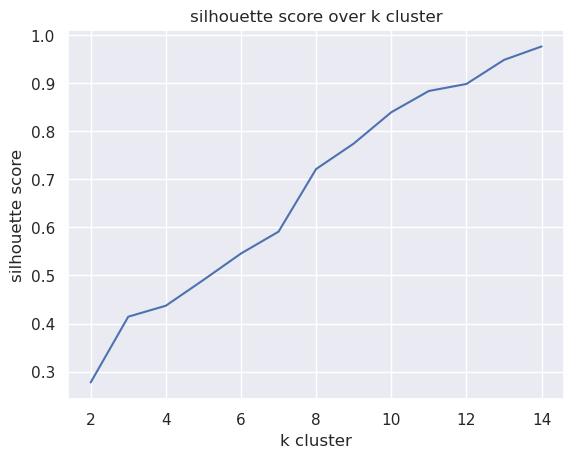

In [50]:
#Further Clustering possible? Can we find superior classes?
# Nur für features, welche beim score des besten models einen gewissen threshold übertreffen
#Oberkategorien finden: zB steigende Studentenzahl - sinkende Autos
# hier werden ähnliche zeitliche verläufe der features geclustered

with open("data/model/best_model_city_results.pkl","rb") as f:
    ct_class = pickle.load(f)

def filter_k_thresh(threshold):
    cls_features = {}
    for feature in model_scores.keys():
        k = max(model_scores[feature],key=model_scores[feature].get)
        #print(model_scores[feature])
        score = model_scores[feature][k]
        if score >= threshold:
            cls_features[feature] = score
    return cls_features

#Clustering nach features mit dem besten time series clustering score
top_features = filter_k_thresh(0.4)
df_ct_class = pd.DataFrame.from_dict(ct_class)[top_features.keys()]

display(df_ct_class.head())

#Clustering nach willkürlich ausgewählten features
top_features = ["Bevölkerung am 1. Januar, insgesamt",
                "Verkehrsmittel für den Arbeitsweg - Anteil Pkw oder Motorrad - %",
                "Zugelassene Pkw je 1000 Einwohner"]
df_ct_class = pd.DataFrame.from_dict(ct_class)[top_features]

onehot = OneHotEncoder(sparse_output=False)
X = onehot.fit_transform(df_ct_class)
#print(onehot.categories_)

d = {}
for k in range(2,15):
    km_model = KMeans(n_clusters = k)
    y_pred = km_model.fit_predict(X)
    d[k] = silhouette_score(X,y_pred)

ax =plt.axes()
ax.plot(d.keys(),d.values())
ax.set_title("silhouette score over k cluster")
ax.set_ylabel("silhouette score")
ax.set_xlabel("k cluster")
plt.show()

#Conclusio: top level cluster sinnlos? score für überschaubare anzahl an klassen ziemlich gering zB k=3 -> ~0.3
# Bei willkürlicher Wahl der features errreicht man ~0.5 bei 4 categorien

In [51]:

km_model = KMeans(n_clusters = 4)
y_pred = km_model.fit_predict(X)
city_cats = {lbl:cls for lbl,cls in zip(df_ct_class.index,y_pred)}
df_urban["cat"] = list(map(lambda x: city_cats[x],list(df_urban.index.get_level_values("kernel"))))
print("silhouette score:",silhouette_score(X,y_pred))

silhouette score: 0.4361494283379027


In [52]:
#Visualize Classification results

def cat_scatter(f1,f2):
    gen = color_gen()
    fig,ax =  plt.figure(figsize=(10,6)),plt.axes()
    sns.scatterplot(data=df_urban,x=f1,y=f2,hue="cat",ax=ax,palette= [next(gen) for i in range(len(df_urban.cat.unique()))])
    plt.show()
    
d1 = widgets.Dropdown(options=list(df_urban.columns))
d2 = widgets.Dropdown(options =list(df_urban.columns))
display(widgets.HBox([d1,d2]))
out14 =  interactive_output(cat_scatter,{"f1":d1,"f2":d2})
out14

Output()

In [53]:
#CLASS STATISTICS
df_urban.groupby("cat").agg(["mean","std"])

Studierende an Hochschuleinrichtungen (ISCED-Stufe 5-8, ab 2014), insgesamt  \
                                                                           mean   
cat                                                                               
0                                         21359.146671                            
1                                         16219.757801                            
2                                         21306.103982                            
3                                         18557.847725                            

                  Bevölkerung am 1. Januar, insgesamt                 \
              std                                mean            std   
cat                                                                    
0    43524.114841                       308263.158909  787839.296585   
1    25416.752010                       200739.509716  288423.859302   
2    44628.148690                       244017.209590  496019.511564   
3    37673.070668                       292993.012315  934335.655745   

    Bevölkerung am 1. Januar, männlich                 \
                                  mean            std   
cat                                                     
0                        150367.863970  390869.727878   
1                         94950.544199  136373.391336   
2                        118985.062704  238205.639917   
3                        141424.898580  453757.255282   

    Bevölkerung am 1. Januar, weiblich                 \
                                  mean            std   
cat                                                     
0                        158684.940737  397341.261775   
1                        105170.755001  152232.059561   
2                        126551.356366  256792.189349   
3                        150509.356346  475456.974738   

    Länge des Radwegenetzes (ausgewiesene Fahrradwege und -spuren) - km  \
                                                                   mean   
cat                                                                       
0                                           137.564161                    
1                                            76.960724                    
2                                           162.981909                    
3                                           117.990914                    

                  ...  \
             std  ...   
cat               ...   
0     192.742493  ...   
1     150.197682  ...   
2    1656.264138  ...   
3     136.543635  ...   

    Preis einer kombinierten Monatskarte (alle öffentlichen Verkehrsmittel) für Fahrten ins Stadtzentrum von 5 bis 10 km - EUR  \
                                                                                                                          mean   
cat                                                                                                                              
0                                            34.078082                                                                           
1                                            31.918443                                                                           
2                                            47.002944                                                                           
3                                            46.161569                                                                           

                \
           std   
cat              
0    20.123954   
1    22.564538   
2    30.721933   
3    27.414040   

    Preis einer Taxifahrt aus einer Entfernung von 5 km in das Stadtzentrum (tagsüber) - EUR  \
                                                                                        mean   
cat                                                                                            
0                                             8.339471                                   

In [54]:
feats = cl_features + ["cat"]

srb = widgets.RadioButtons(options = ["std","minmax"])
interact(plot_radar_chart,df=fixed(df_urban[feats]),kmeans=fixed(km_model),scaler=srb);

interactive(children=(RadioButtons(description='scaler', options=('std', 'minmax'), value='std'), Output()), _…

In [56]:
#TODO: Map mit Städten eingefärbt nach cluster class
with open("data/geo/URAU_LB_2020_4326.geo.json","r",encoding="utf-8") as f:
    geo_data = json.load(f)

def ct_cls_styler(*args):
    ct_id = args[0]["properties"]["FID"]
    ct_cat = city_cats[ct_id]
    return {"color":sns.color_palette().as_hex()[ct_cat]}

def ct_cat_click(**kwargs):
    loc = kwargs["feature"]["geometry"]["coordinates"][::-1]
    fid = kwargs["feature"]["properties"]["FID"]
    m8.add_layer(Popup(location=loc,child = widgets.HTML("<b>{}<b>".format(fid))))

m8 = Map(center=(49.15,12.35), zoom = 4, basemap=basemaps.CartoDB.Positron)
geo_data = filter_geo("FID",list(city_cats.keys()),geo_data)

geojson = GeoJSON(data = geo_data,point_style={"radius":5,"fillOpacity":0.6,"weight":0},style_callback=ct_cls_styler)
geojson.on_click(ct_cat_click)
m8.add_layer(geojson)
l = LegendControl({"class {}".format(i):sns.color_palette().as_hex()[i] for i in set(city_cats.values())},position = "topright")
m8.add_control(l)
m8

#Conclusio: Some countries show high density of cities of one category -> might be due to a missing data handling strategy
# BSP. in DE/ES ausgewogene Clustervielfalt, da hier die Dantenverfügbarkeit groß ist.
# in FR homogenes Bild, da hier sehr wenige Daten übermittelt wurden

Map(center=[49.15, 12.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

# Conclusio

In [119]:
#Interesting questions:
#How does the avg. urban citizen (Stadtbewohner) move around by the class of the country?
# How does this vary within all cities of a specific country cluster? 

In [120]:
#Questions that remain unanswered:
# How does mobility in urban regions differ from rural areas?

In [121]:
"""
#USED FOR WRITING GEOJSON
with open("data/geo/URAU_LB_2020_4326_.geo.json","r",encoding="utf-8") as f:
    geo_data = json.load(f)

filter_geo("CNTR_CODE","PL",geo_data)
def write_PL():
    for f in geo_data["features"]:
        if f["properties"]["CNTR_CODE"] == "PL":
            name = f["properties"]["FID"] 
            f["properties"]["FID"] = name+"1"
            
with open("data/geo/URAU_LB_2020_4326.geo.json","w",encoding="utf-8") as f:
    json.dump(geo_data,f)
"""       

'\n#USED FOR WRITING GEOJSON\nwith open("data/geo/URAU_LB_2020_4326_.geo.json","r",encoding="utf-8") as f:\n    geo_data = json.load(f)\n\nfilter_geo("CNTR_CODE","PL",geo_data)\ndef write_PL():\n    for f in geo_data["features"]:\n        if f["properties"]["CNTR_CODE"] == "PL":\n            name = f["properties"]["FID"] \n            f["properties"]["FID"] = name+"1"\n            \nwith open("data/geo/URAU_LB_2020_4326.geo.json","w",encoding="utf-8") as f:\n    json.dump(geo_data,f)\n'

In [ ]:
#TODO GENERAL:
#remove XK from df_urban und df_urban_missing, da gar keine Werte vorhanden